In [85]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib import rcParams
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

In [86]:
# Import train data
ne_train = pd.read_csv("../../data/ne_train.csv")
s_train = pd.read_csv("../../data/s_train.csv")

# Import test data
ne_test = pd.read_csv("../../data/ne_test.csv")
s_test = pd.read_csv("../../data/s_test.csv")

# Plots
- Both have time trends --> may be non-stationary/trend stationary

<Axes: title={'center': 'Time series graph of COVID-19 confirmed cases in New England'}, xlabel='date', ylabel='Number of confirmed cases'>

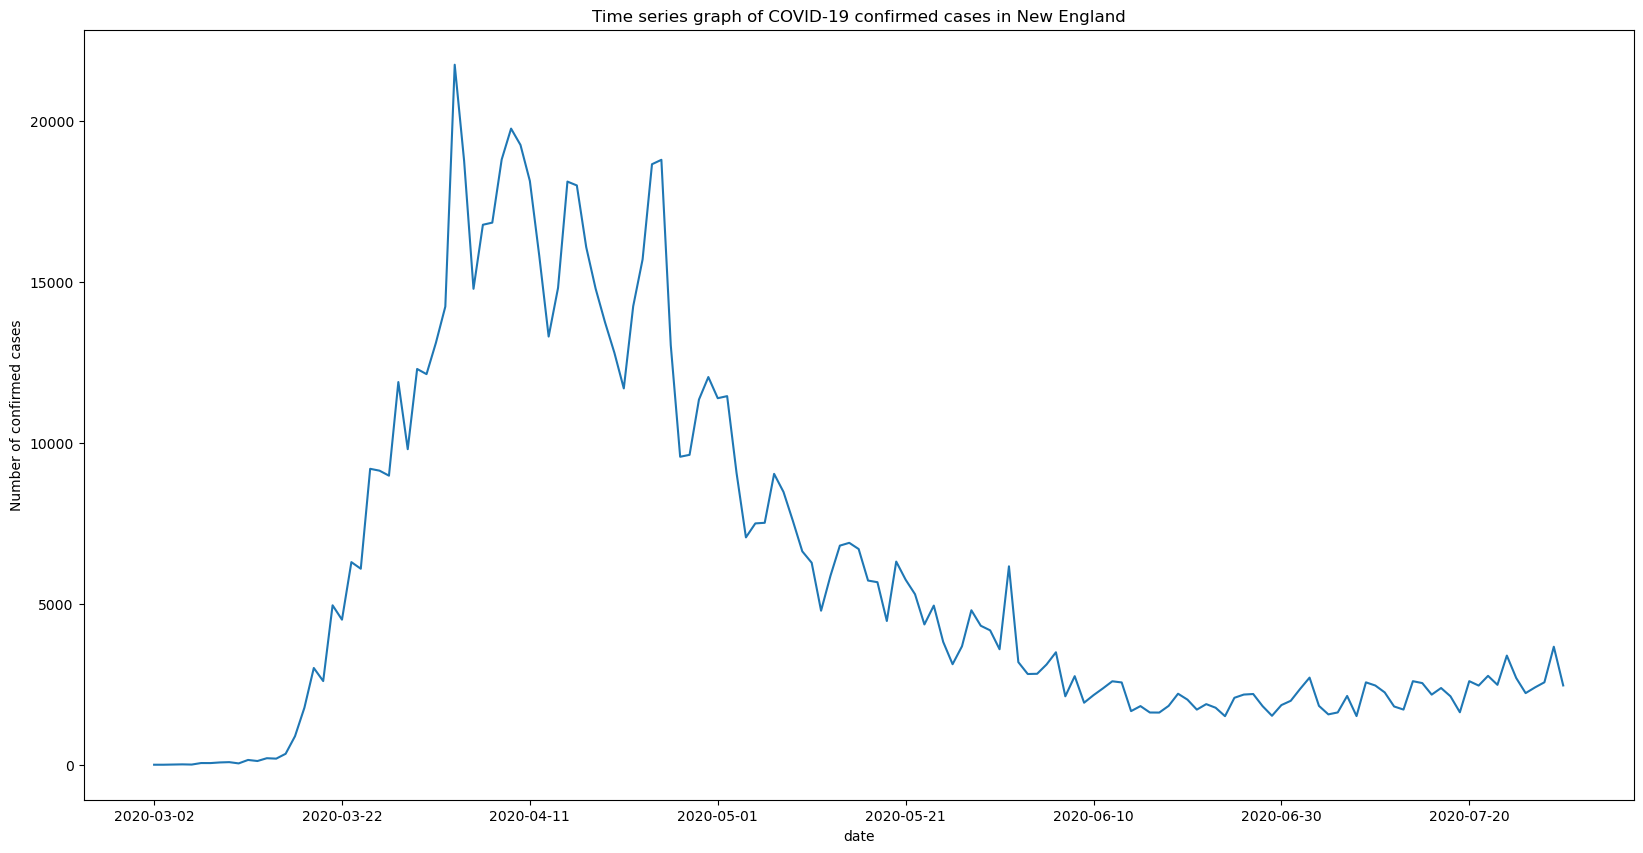

In [202]:
ne_train.plot(x = "date", y = "covid_19_confirmed_cases", figsize = (20,10),
             title = "Time series graph of COVID-19 confirmed cases in New England",
             ylabel = "Number of confirmed cases",
             legend = False)

<Axes: title={'center': 'Time series graph of COVID-19 confirmed cases in the South'}, xlabel='date', ylabel='Number of confirmed cases'>

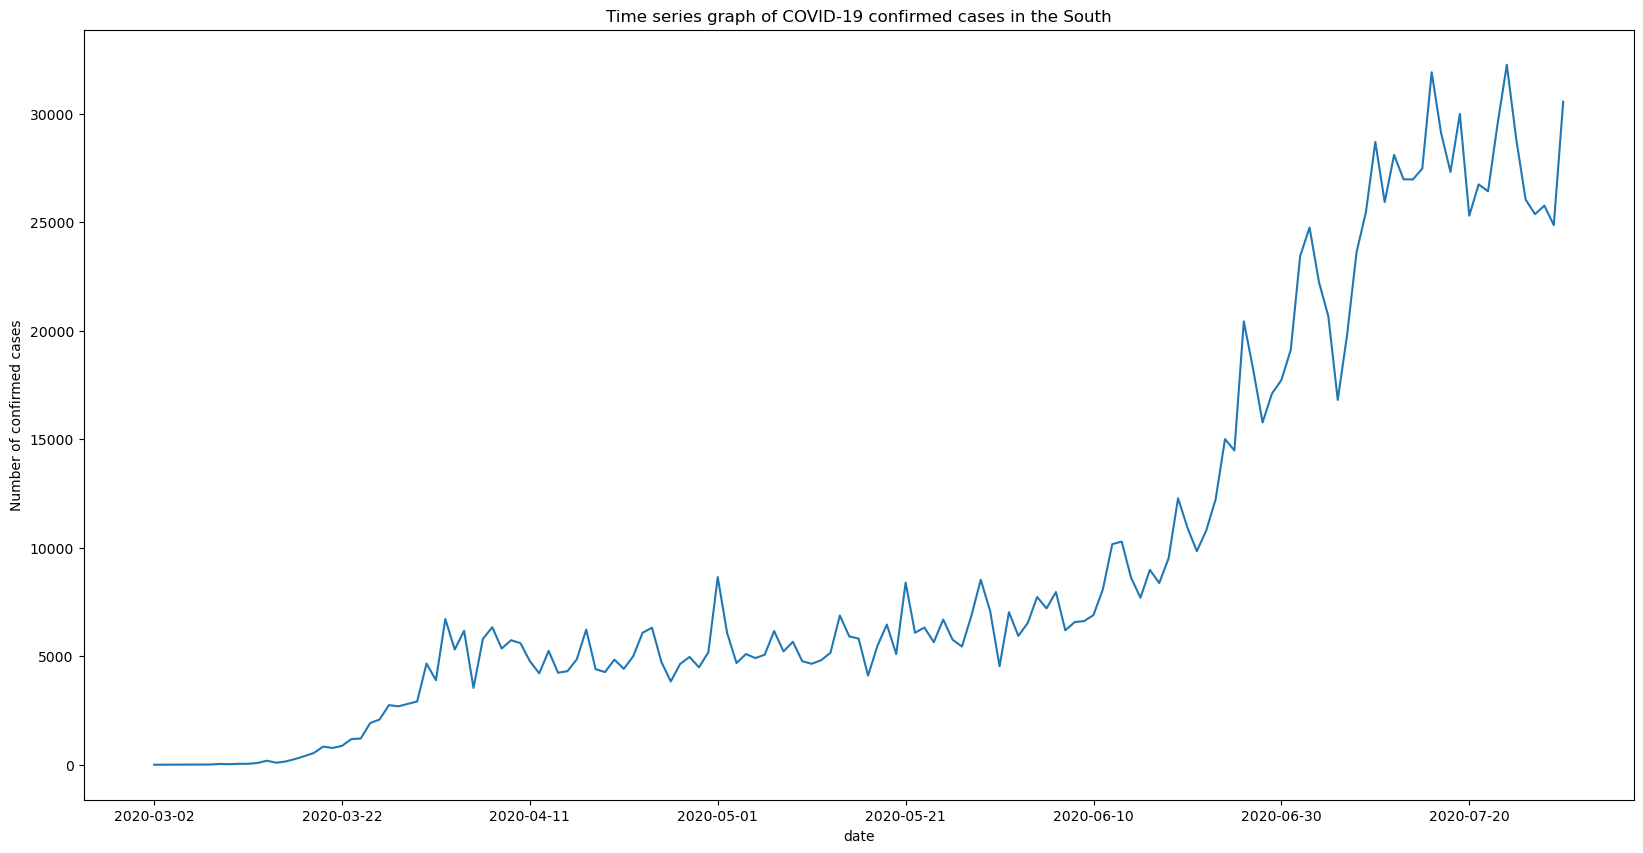

In [203]:
s_train.plot(x = "date", y = "covid_19_confirmed_cases", figsize = (20,10),
             title = "Time series graph of COVID-19 confirmed cases in the South",
             ylabel = "Number of confirmed cases",
             legend = False)

# Seasonality
- A time series with a trend or seasonality is non-stationary
- Remove early values of 0 --> seasonal_decompose to check seasonality
- NE: Seasonality
- S: Seasonality

In [87]:
ne_train.date = pd.to_datetime(ne_train.date)
s_train.date = pd.to_datetime(ne_train.date)

In [205]:
ne_season_train = ne_train.set_index("date")
s_season_train = s_train.set_index("date")

In [206]:
ne_decomposition = seasonal_decompose(ne_season_train["covid_19_confirmed_cases"], model = "additive")

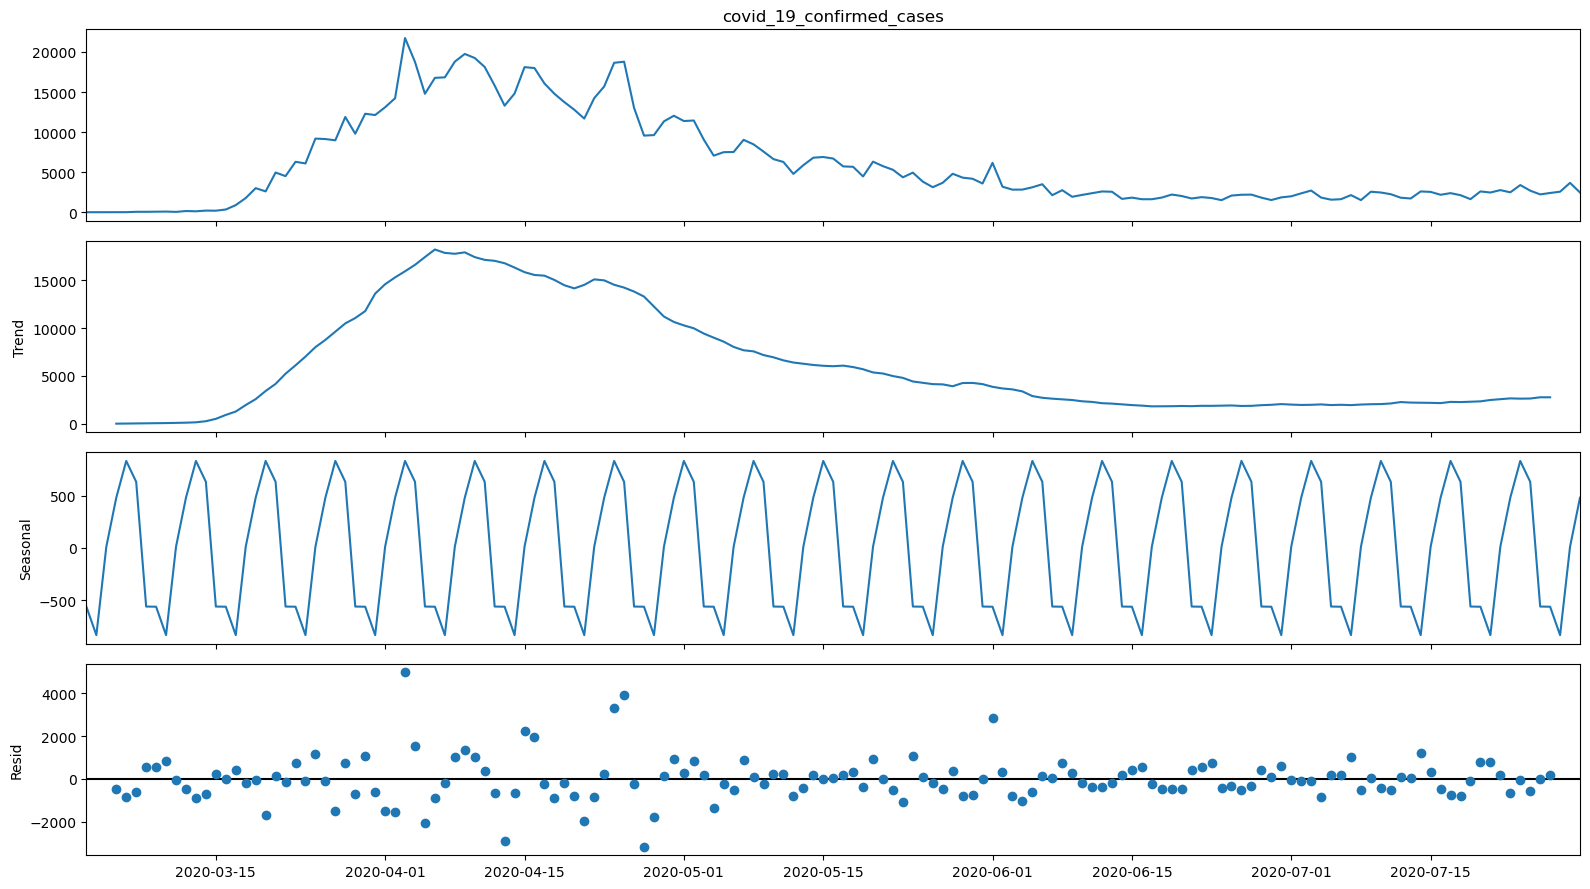

In [207]:
fig = ne_decomposition.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [208]:
s_decomposition = seasonal_decompose(s_season_train["covid_19_confirmed_cases"], model = "additive")

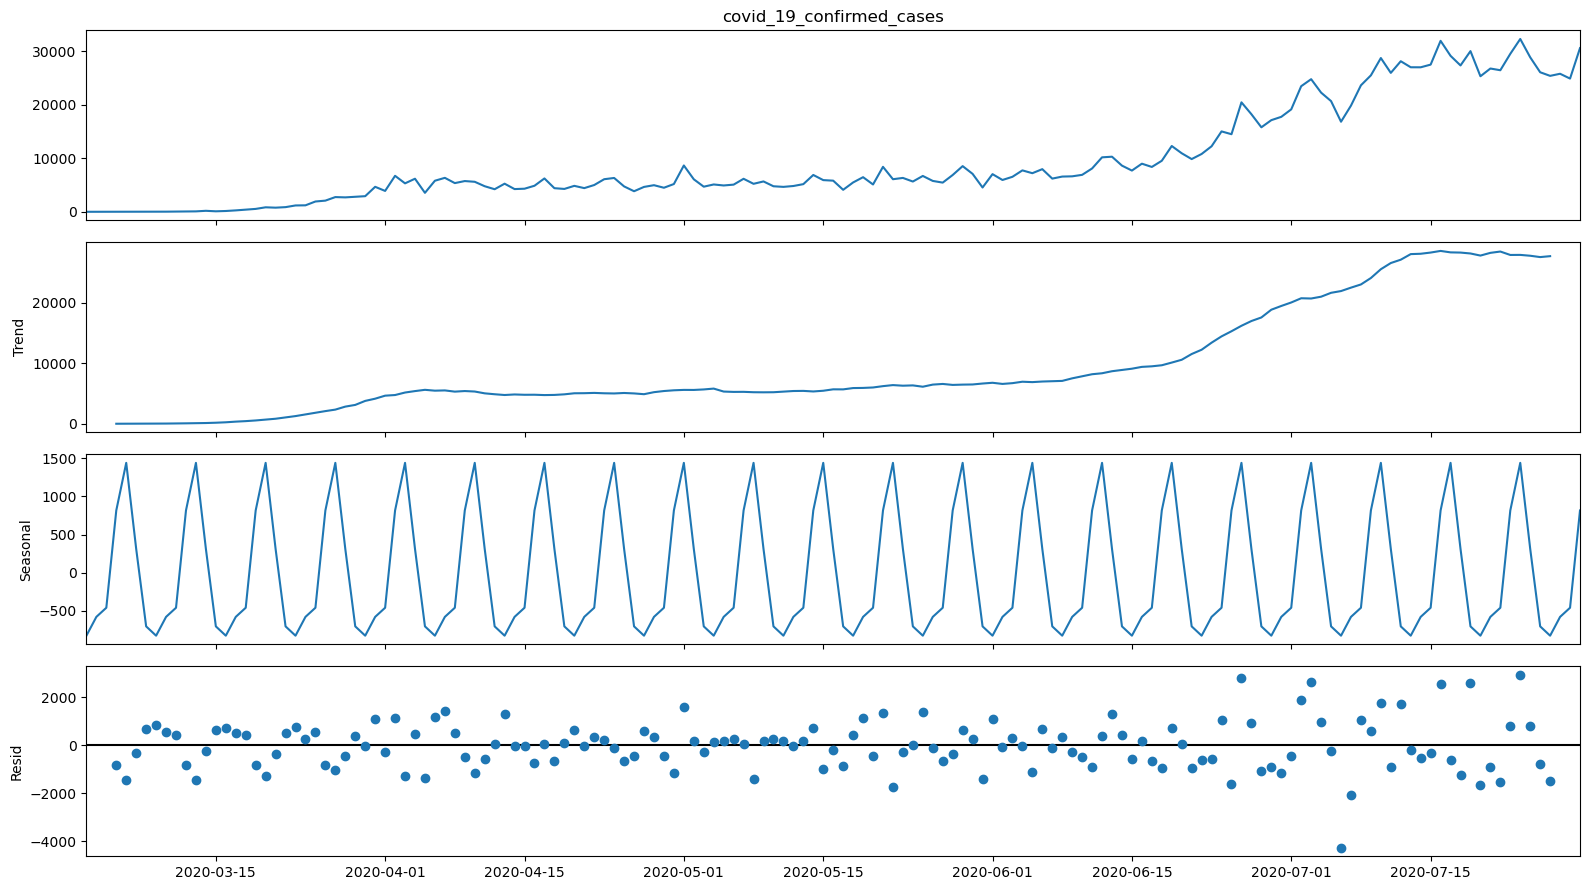

In [209]:
fig = s_decomposition.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

# Stationary Tests

- Before differencing & removing trends
    - NE: adf (non-stationary) & kpss (non-stationary) --> non-stationary
    - S: adf (non-stationary) & kpss (non-stationary) --> non-stationary

In [210]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [211]:
adf_test(ne_train["covid_19_confirmed_cases"])

Results of Dickey-Fuller Test:
Test Statistic                  -2.600670
p-value                          0.092859
#Lags Used                       9.000000
Number of Observations Used    141.000000
Critical Value (1%)             -3.477601
Critical Value (5%)             -2.882266
Critical Value (10%)            -2.577822
dtype: float64


In [212]:
adf_test(s_train["covid_19_confirmed_cases"])

Results of Dickey-Fuller Test:
Test Statistic                  -0.593975
p-value                          0.872338
#Lags Used                      14.000000
Number of Observations Used    136.000000
Critical Value (1%)             -3.479372
Critical Value (5%)             -2.883037
Critical Value (10%)            -2.578234
dtype: float64


In [213]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [214]:
kpss_test(ne_train["covid_19_confirmed_cases"])

Results of KPSS Test:
Test Statistic           0.560788
p-value                  0.027976
#Lags Used               8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [215]:
kpss_test(s_train["covid_19_confirmed_cases"])

Results of KPSS Test:
Test Statistic           1.42055
p-value                  0.01000
#Lags Used               8.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64


## Remove Non-stationarity

### Remove trend
- Log transform
- NE: adf (stationary) & kpss (stationary) --> strictly stationary --> no need to difference
- S: adf (non-stationary) & kpss (non-stationary) --> need to difference

In [88]:
ne_train.covid_19_confirmed_cases = np.log(ne_train.covid_19_confirmed_cases)

<Axes: title={'center': 'Time series graph of COVID-19 confirmed cases in New England'}, xlabel='date', ylabel='Number of confirmed cases'>

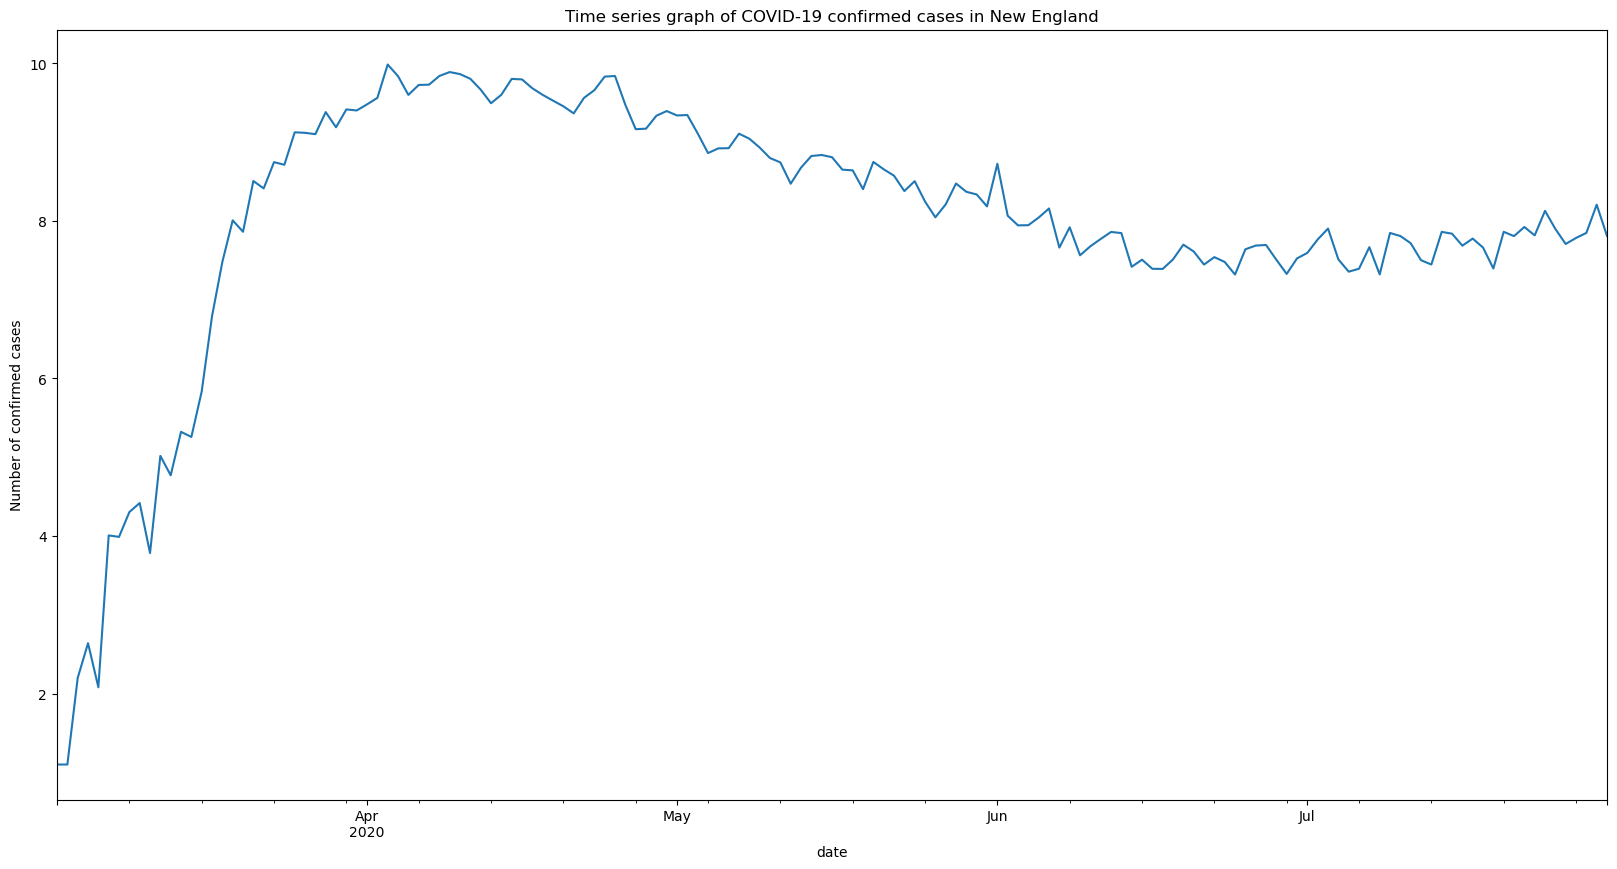

In [217]:
ne_train.plot(x = "date", y = "covid_19_confirmed_cases", figsize = (20,10),
             title = "Time series graph of COVID-19 confirmed cases in New England",
             ylabel = "Number of confirmed cases",
             legend = False)

In [218]:
adf_test(ne_train.covid_19_confirmed_cases)

Results of Dickey-Fuller Test:
Test Statistic                  -4.187454
p-value                          0.000692
#Lags Used                      14.000000
Number of Observations Used    136.000000
Critical Value (1%)             -3.479372
Critical Value (5%)             -2.883037
Critical Value (10%)            -2.578234
dtype: float64


In [219]:
kpss_test(ne_train.covid_19_confirmed_cases)

Results of KPSS Test:
Test Statistic           0.267417
p-value                  0.100000
#Lags Used               8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [89]:
s_train.covid_19_confirmed_cases = np.log(s_train.covid_19_confirmed_cases)

<Axes: title={'center': 'Time series graph of COVID-19 confirmed cases in the South'}, xlabel='date', ylabel='Number of confirmed cases'>

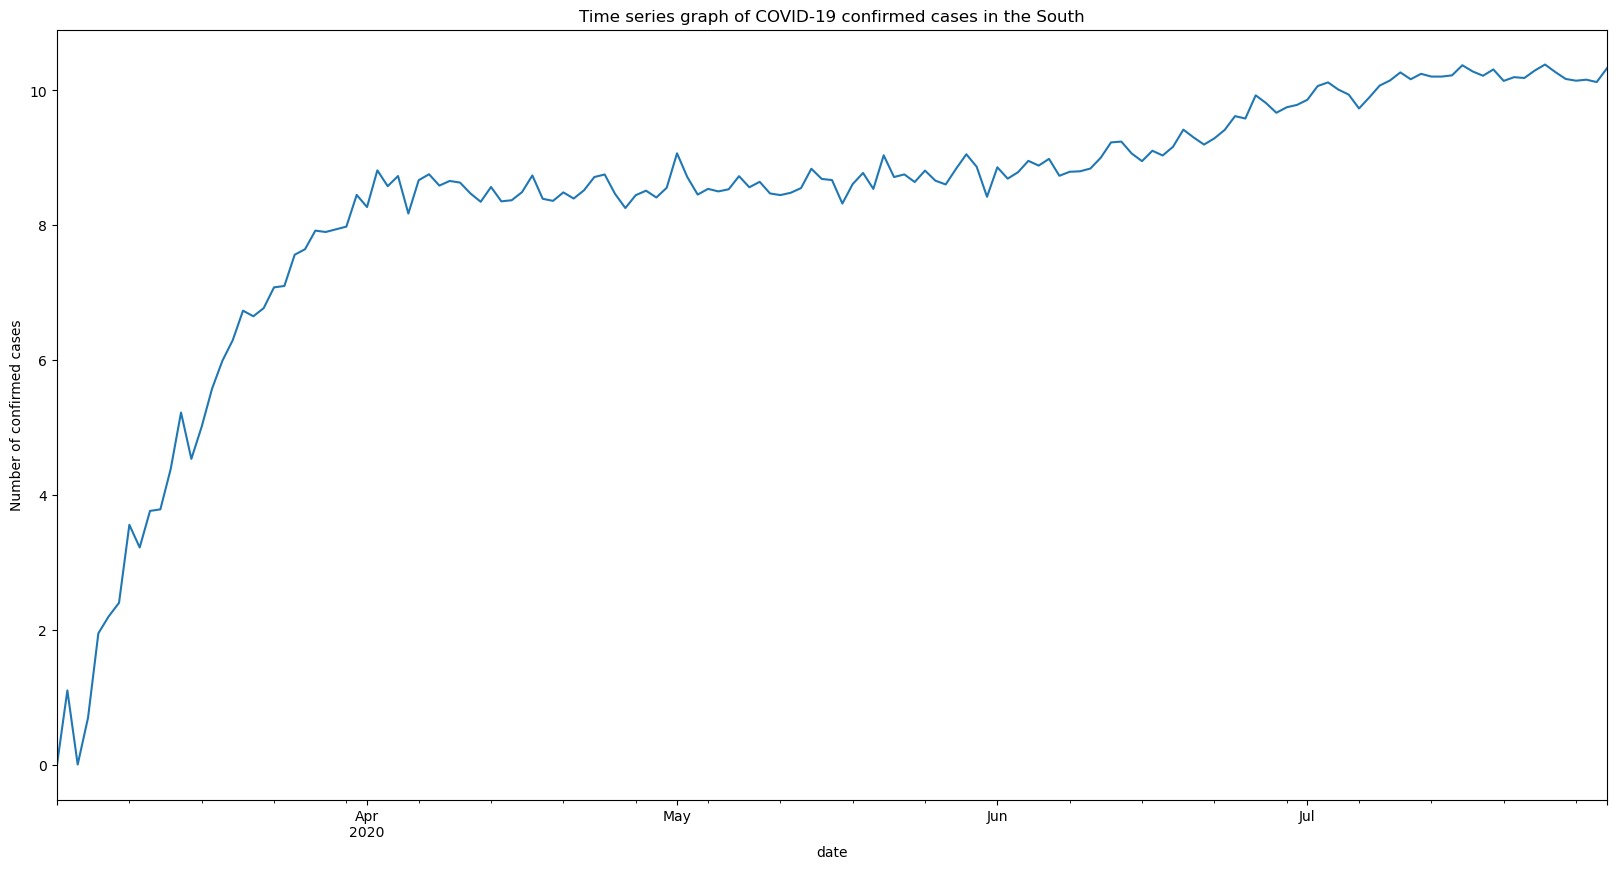

In [221]:
s_train.plot(x = "date", y = "covid_19_confirmed_cases", figsize = (20,10),
             title = "Time series graph of COVID-19 confirmed cases in the South",
             ylabel = "Number of confirmed cases",
             legend = False)

In [222]:
adf_test(s_train.covid_19_confirmed_cases)

Results of Dickey-Fuller Test:
Test Statistic                  -1.495770
p-value                          0.535603
#Lags Used                      11.000000
Number of Observations Used    139.000000
Critical Value (1%)             -3.478294
Critical Value (5%)             -2.882568
Critical Value (10%)            -2.577983
dtype: float64


In [223]:
kpss_test(s_train.covid_19_confirmed_cases)

Results of KPSS Test:
Test Statistic           1.178651
p-value                  0.010000
#Lags Used               8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


### Remove seasonality
- S: differecing = 1 --> adf (stationary) & kpss (non-stationary) --> series is difference stationary
    - Cannot make it strictly non-stationary
    - Tried not log transformation & differencing --> series becomes trend stationary
    - Could still have some unremoved trends & seasonlity --> Check ACF & PACF & Potential SARIMA model

In [224]:
s_train_y = pd.Series(s_train["covid_19_confirmed_cases"]).diff(periods = 1).dropna()

s_train_transformed = pd.merge(s_train.date, s_train_y, left_index=True, right_index=True)

<Axes: title={'center': 'Time series graph of COVID-19 confirmed cases in the South'}, xlabel='date', ylabel='Number of confirmed cases'>

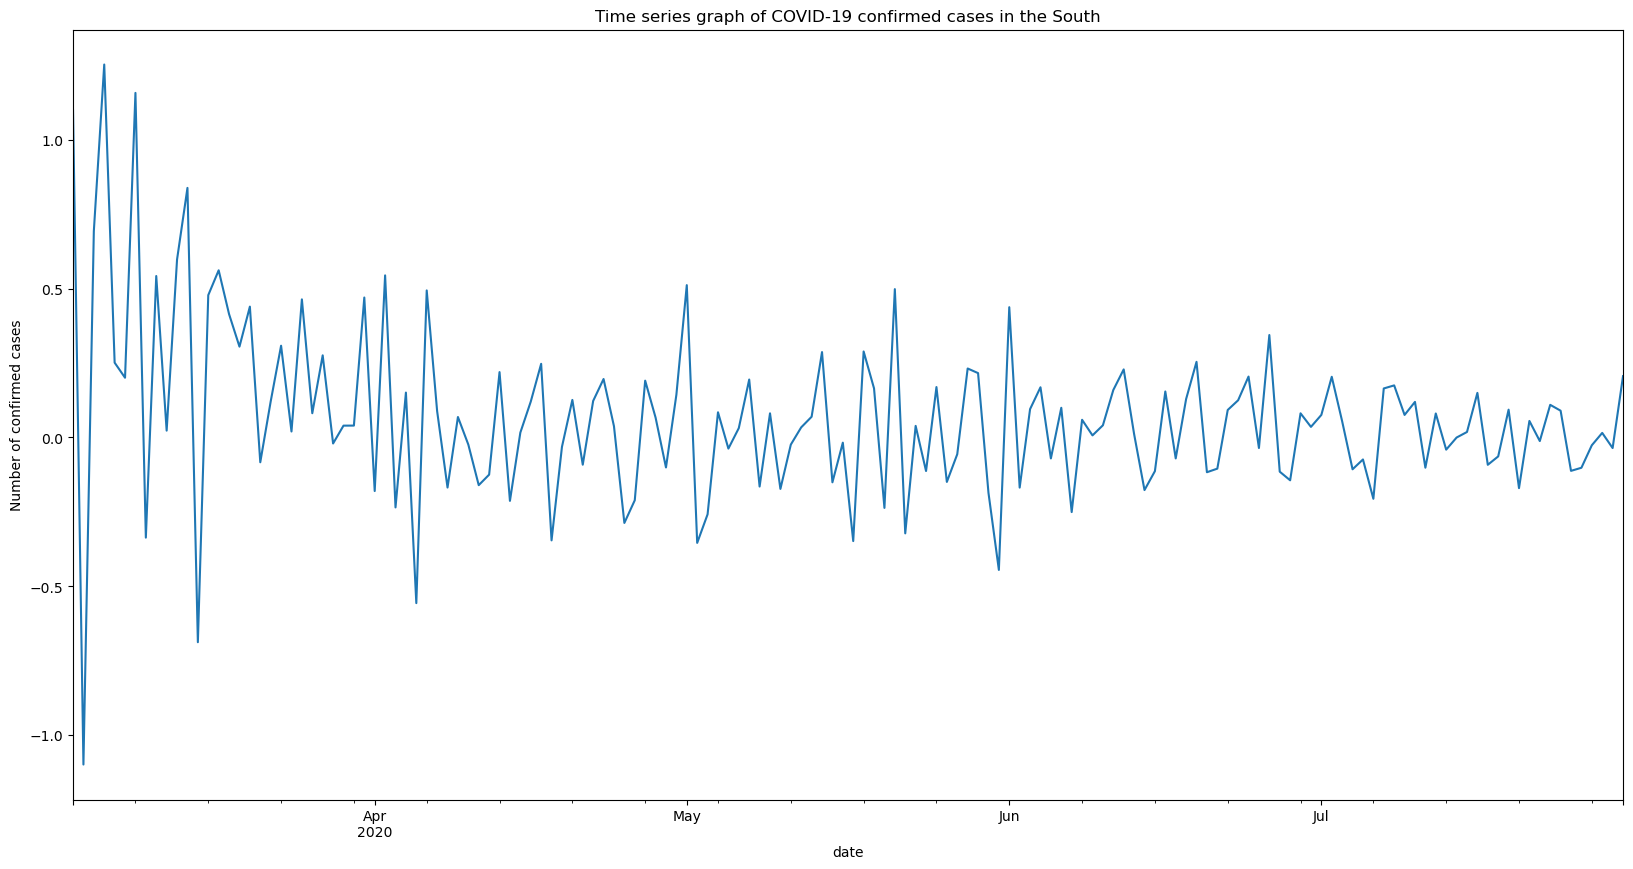

In [225]:
s_train_transformed.plot(x = "date", y = "covid_19_confirmed_cases", figsize = (20,10),
             title = "Time series graph of COVID-19 confirmed cases in the South",
             ylabel = "Number of confirmed cases",
             legend = False)

In [226]:
adf_test(s_train_y)

Results of Dickey-Fuller Test:
Test Statistic                  -4.651526
p-value                          0.000104
#Lags Used                      10.000000
Number of Observations Used    139.000000
Critical Value (1%)             -3.478294
Critical Value (5%)             -2.882568
Critical Value (10%)            -2.577983
dtype: float64


In [227]:
kpss_test(s_train_y)

Results of KPSS Test:
Test Statistic           0.918802
p-value                  0.010000
#Lags Used               6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


# ACF
- When a clear trend exists in a time series, the autocorrelation tends to be high at small lags like 1 or 2
- When seasonality exists, the autocorrelation goes up periodically at larger lags
- NE: no clear trend; no seasonality
    - Tail off is observed --> AR (AutoRegressive Model)
- S: no clear trend; no seasonality
    - Tail off is observed --> AR (AutoRegressive Model)

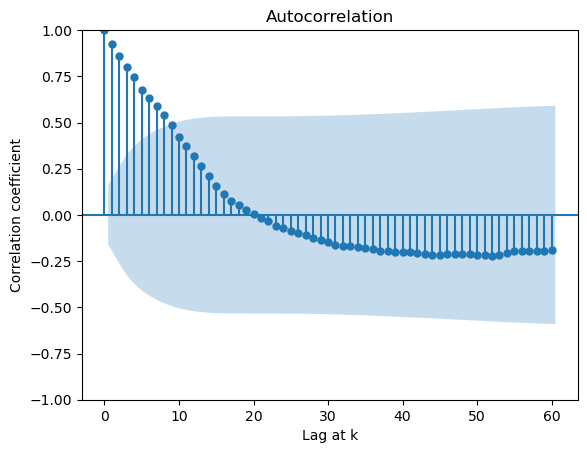

In [228]:
fig = tsaplots.plot_acf(ne_train["covid_19_confirmed_cases"], lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

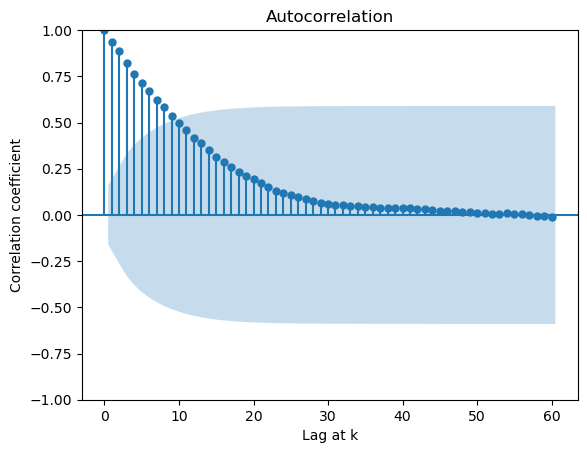

In [229]:
fig = tsaplots.plot_acf(s_train["covid_19_confirmed_cases"], lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

# PACF
- NE: Cut off at lag 1; Does not tail off
- S: Cut off at lag 1; Does not tail off

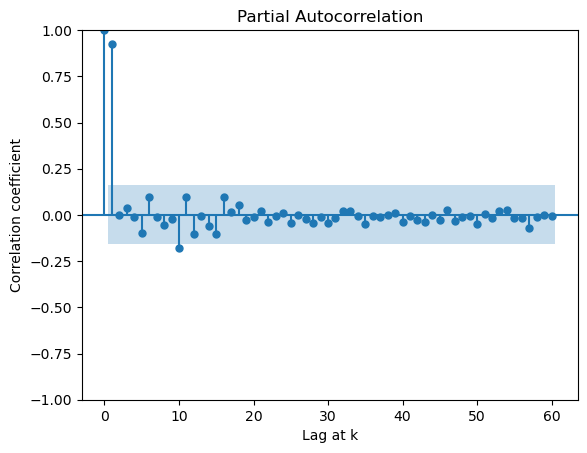

In [230]:
fig = tsaplots.plot_pacf(ne_train["covid_19_confirmed_cases"], lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

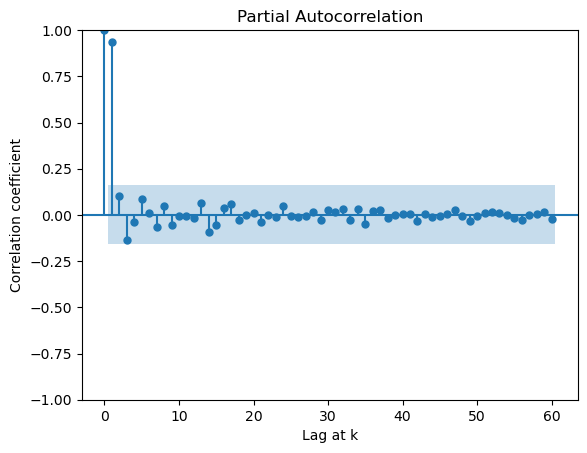

In [231]:
fig = tsaplots.plot_pacf(s_train["covid_19_confirmed_cases"], lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

# NE Model
- (1, 0, 0)
    - AR Model
    - ACF graph shows tail off
    - No need to difference 
    - PACF shows cut off at lag 1
- Residual stats show that residual looks like white noise with normal distribution and mean around 0
- ACF and PACF plots of residuals show barely any significant spikes for larger lags
    - Residuals are close to white noise
    - No bias in prediction
- MAE on train set = 858 confirmed cases
- MAE on test set = 574 confirmed cases

In [90]:
ne_train_transformed = pd.merge(ne_train.date, ne_train["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
ne_test_transformed = pd.merge(ne_test.date, ne_test["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)

In [91]:
ne_train_transformed.set_index("date", inplace = True)
ne_test_transformed.set_index("date", inplace = True)

## (1,0,0) Model

In [92]:
ne_model = ARIMA(ne_train_transformed, order=(1,0,0))
ne_model_fit = ne_model.fit()

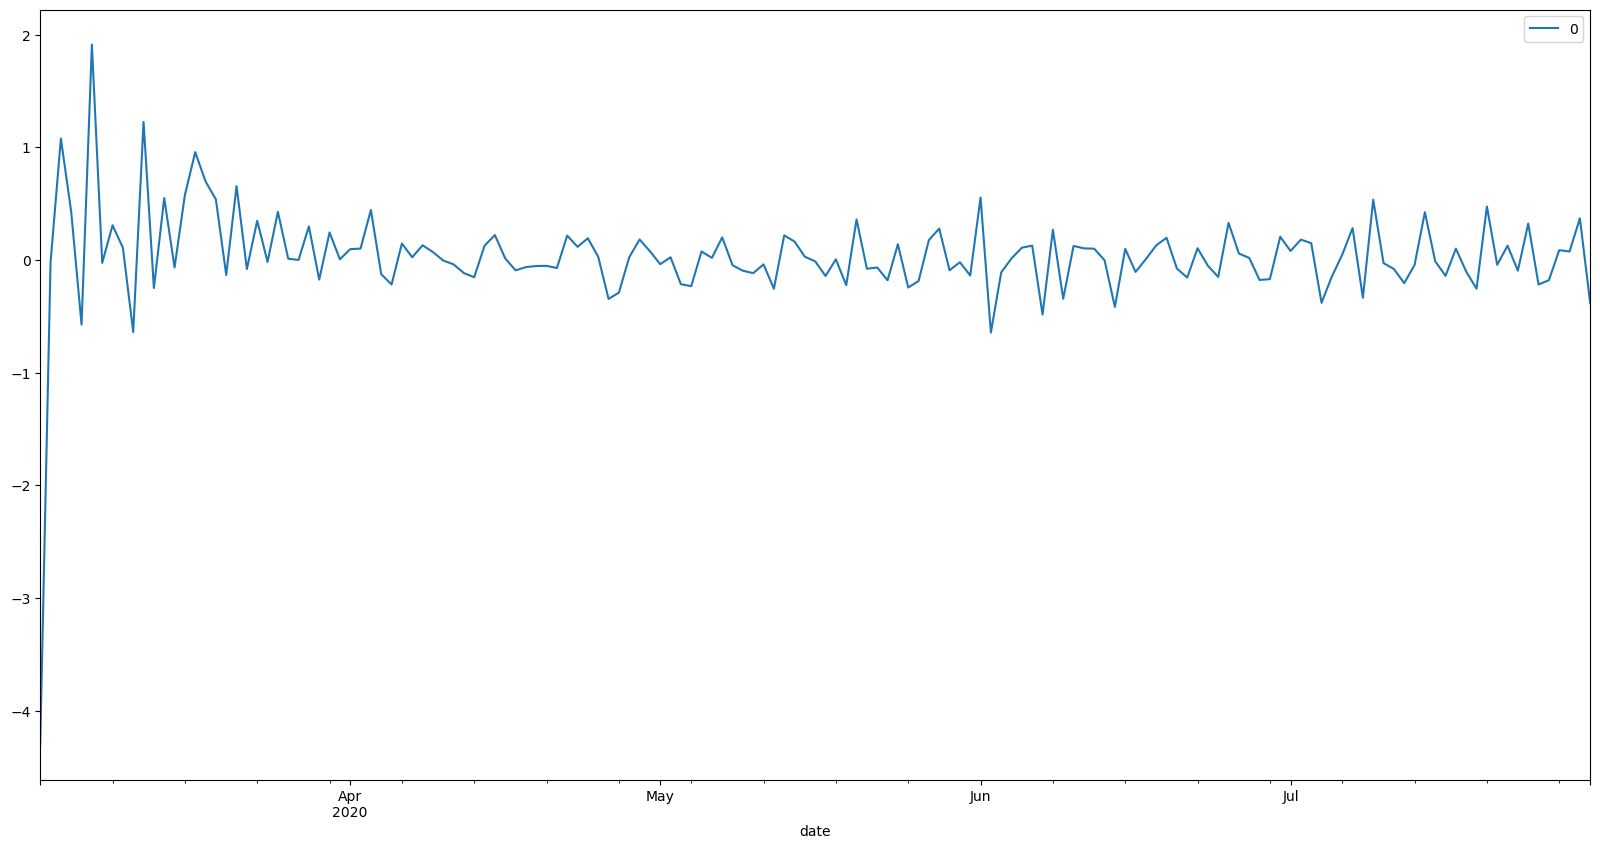

In [93]:
# line plot of residuals
residuals = DataFrame(ne_model_fit.resid)
residuals.plot(figsize = (20,10))
plt.show()

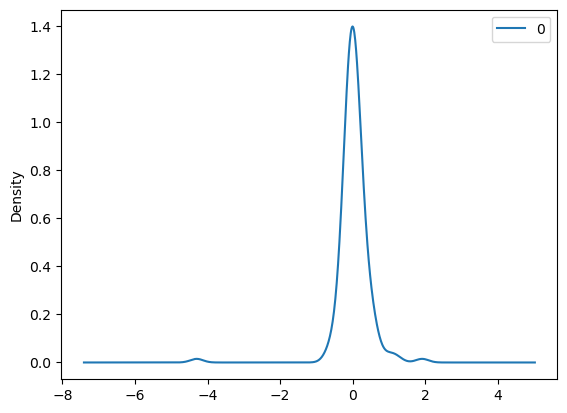

In [94]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

In [95]:
# summary stats of residuals
print(residuals.describe())

                0
count  151.000000
mean     0.028331
std      0.477224
min     -4.298317
25%     -0.116065
50%      0.008351
75%      0.156575
max      1.911961


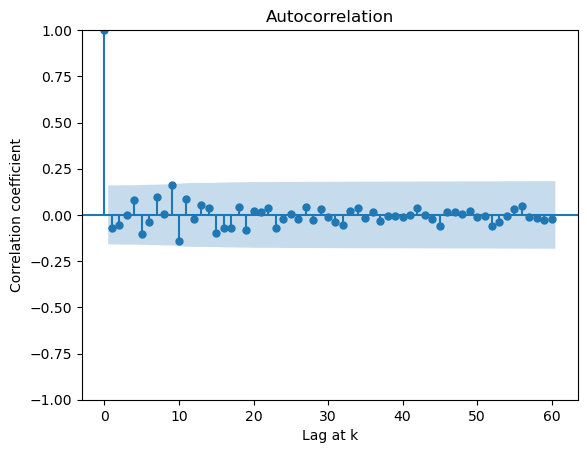

In [96]:
# ACF plot of residuals
fig = tsaplots.plot_acf(residuals, lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

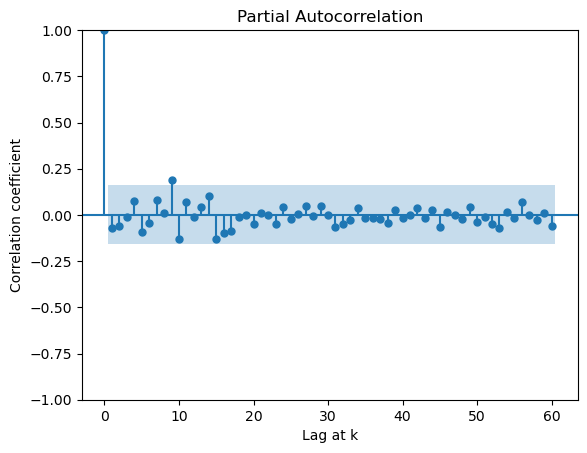

In [97]:
# PACF plot of residuals
fig = tsaplots.plot_pacf(residuals, lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

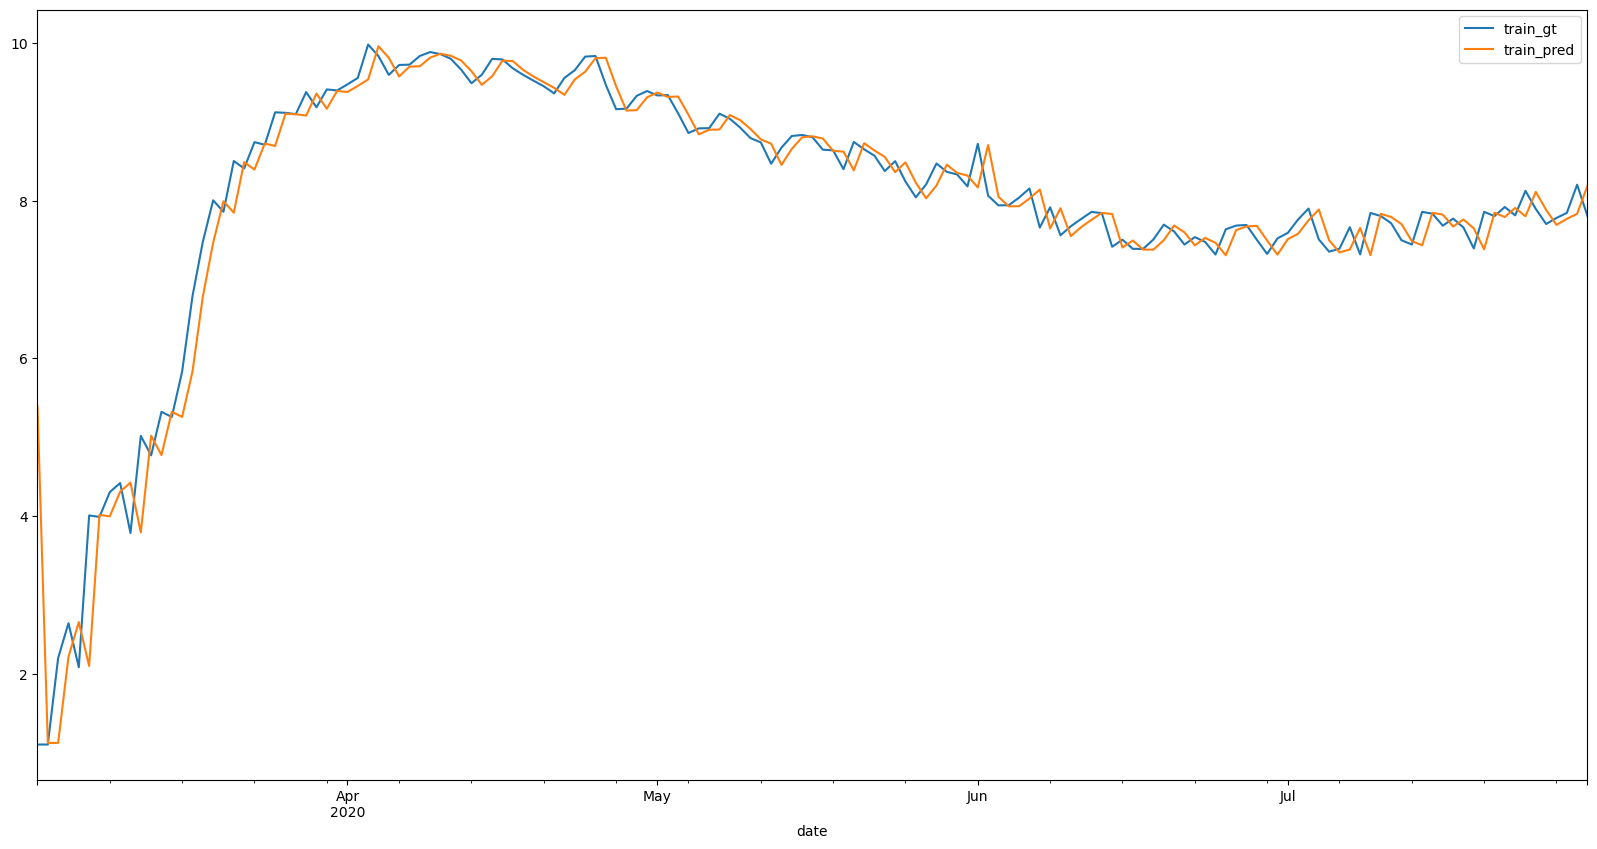

In [98]:
# Visualizing train data fitted values
ne_train_pred = ne_model_fit.fittedvalues
pd.concat([ne_train_transformed, ne_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

In [99]:
# MAE on train data
mean_absolute_error(np.exp(ne_train_transformed), np.exp(ne_train_pred))

858.4879750733982

## NE Model Forecast

In [100]:
ne_test_transformed.index = pd.to_datetime(ne_test_transformed.index)

In [101]:
ne_test_pred = ne_model_fit.predict(start = len(ne_train_transformed), 
                                    end = len(ne_train_transformed) + len(ne_test_transformed) -1)

In [102]:
ne_test_pred = np.exp(ne_test_pred)

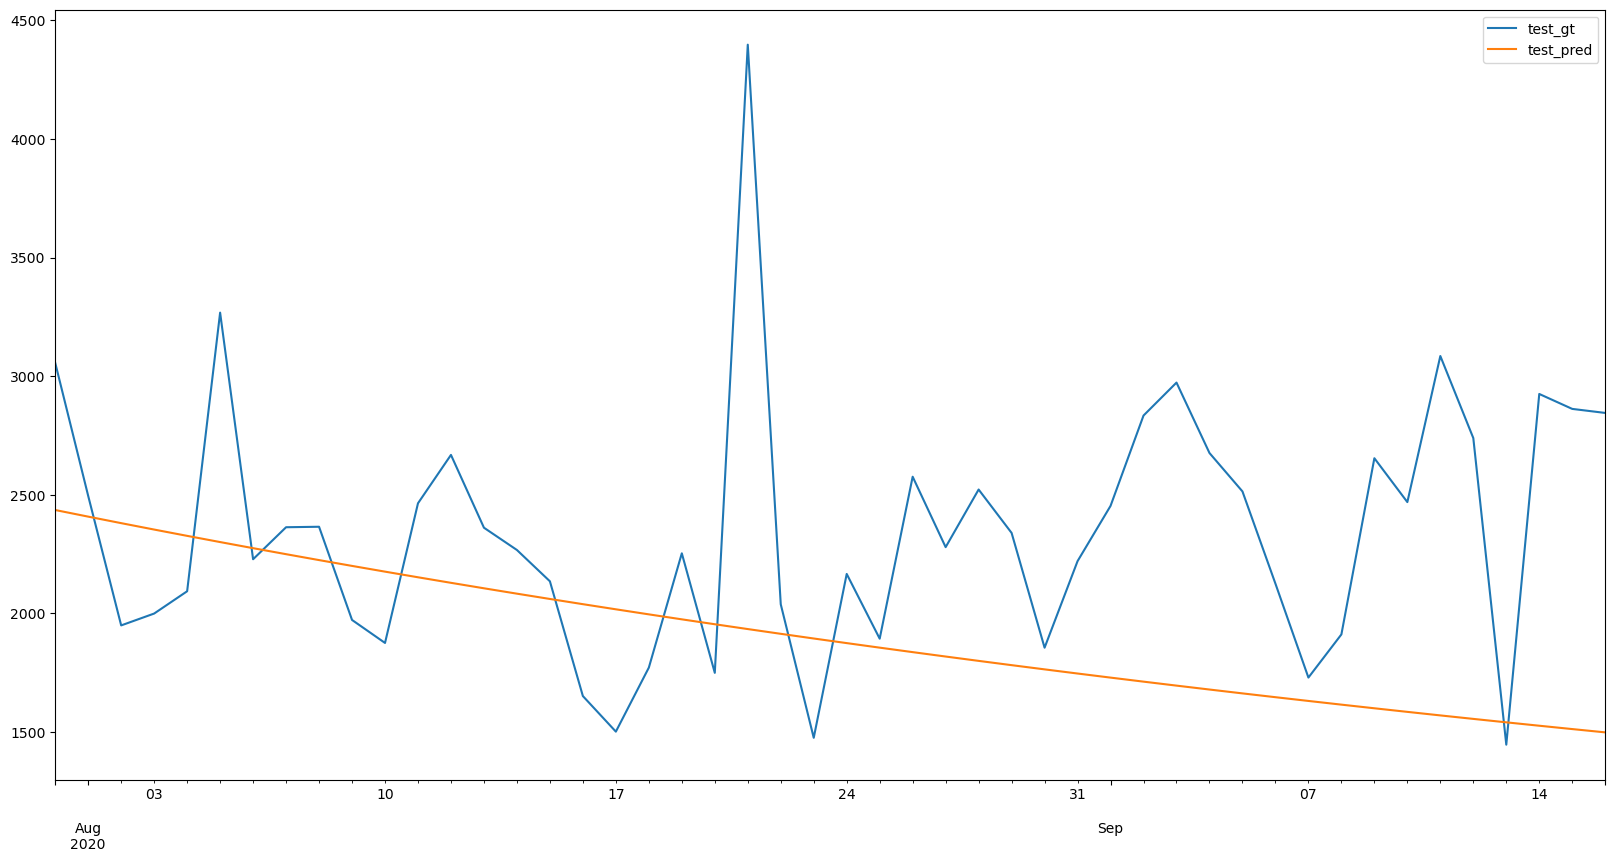

In [103]:
# Visualizing test data fitted values
pd.concat([ne_test_transformed, ne_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [104]:
# MAE on test data
mean_absolute_error(ne_test_transformed, ne_test_pred)

574.1854997062104

## Grid Search on NE Region
- Alternative to diagnostic plots + heristic rules
- Created validation set 90:10
- Best model = (1,1,0)
    - MAE on validation set = 302 confirmed cases
    - MAE on test set = 466 confirmed cases

In [109]:
ne_train_tune = ne_train_transformed[:135]
ne_val_tune = ne_train_transformed[135:]

In [110]:
def evaluate_arima_model(train, val, arima_order):
    # Fit on Train
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    # Predict on Validation set 
    val_pred = model_fit.predict(start = len(ne_train_tune), 
                                    end = len(ne_train_tune) + len(ne_val_tune) -1)
    
    return mean_absolute_error(np.exp(val), np.exp(val_pred))

In [111]:
def evaluate_models(train, val, p_val, d_val, q_val):
    # Initialise Grid Search
    df = pd.DataFrame(columns = ["model", "maes"])
    for p in p_val:
        for d in d_val:
            for q in q_val:
                order = (p,d,q)
    # Grid Searching
                mae = evaluate_arima_model(train, val, order)
                df.loc[len(df.index)] = [order, mae]
    return df

In [112]:
# Grid Search on NE Region
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
ne_grid = evaluate_models(ne_train_tune, ne_val_tune, p_values, d_values, q_values)

In [115]:
ne_grid.sort_values(by = "maes")[:5]

,model,maes
12,"(1, 1, 0)",302.075169
4,"(0, 1, 1)",304.191563
13,"(1, 1, 1)",305.991999
23,"(2, 1, 2)",310.604405
39,"(6, 1, 0)",319.839494


## (1,1,0) Model

In [116]:
ne_model = ARIMA(ne_train_transformed, order=(1,1,0))
ne_model_fit = ne_model.fit()

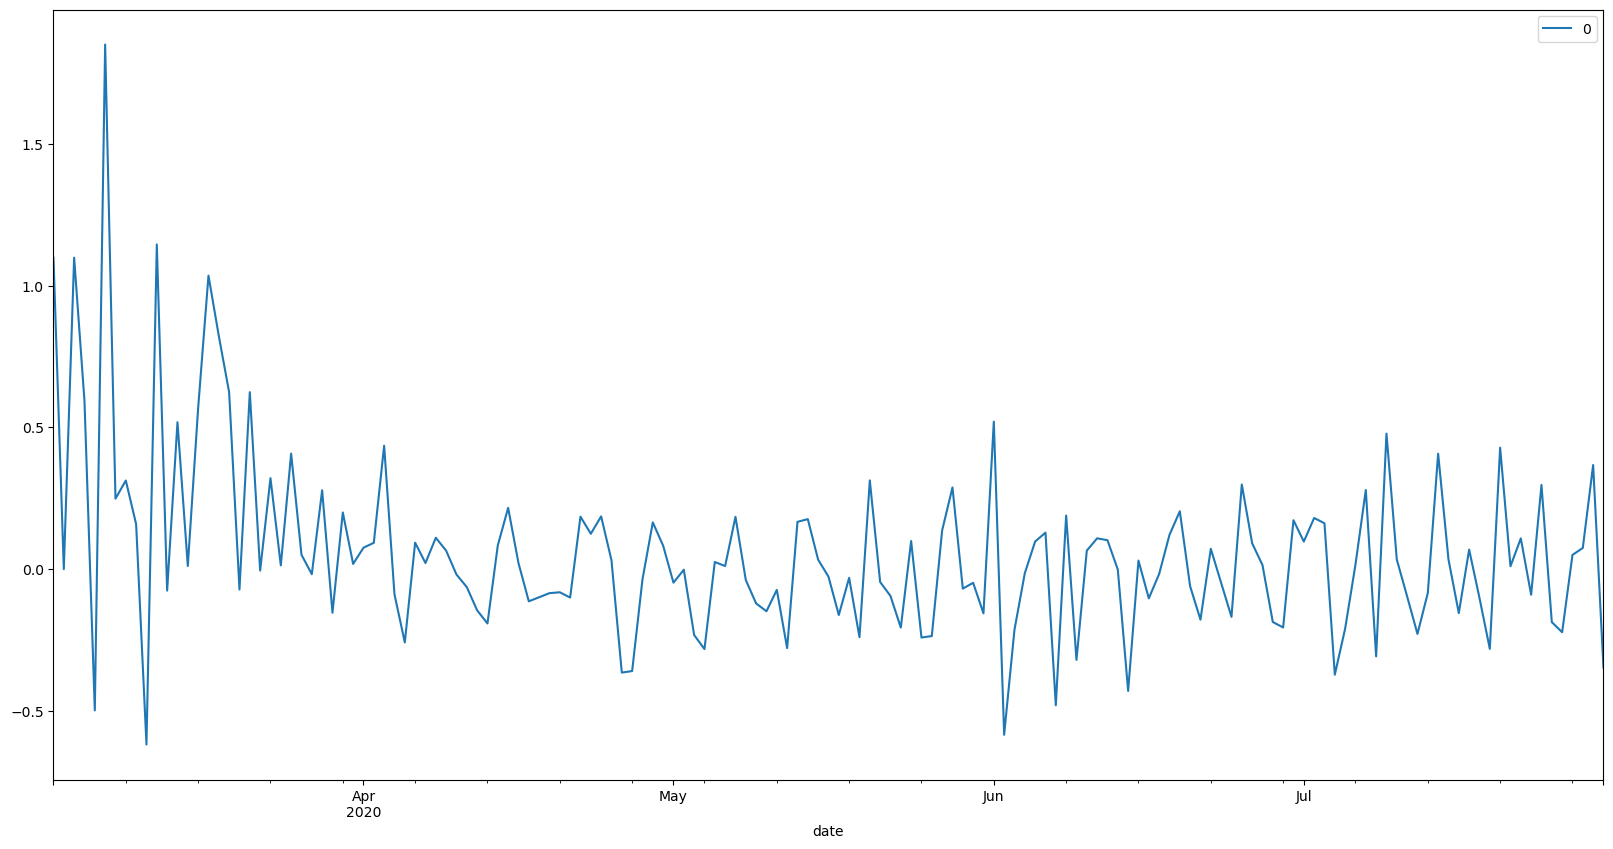

In [117]:
# line plot of residuals
residuals = DataFrame(ne_model_fit.resid)
residuals.plot(figsize = (20,10))
plt.show()

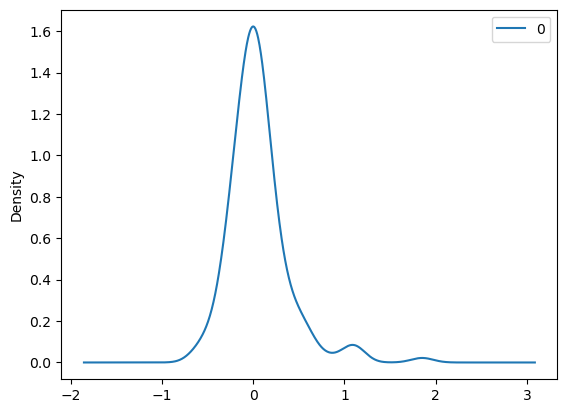

In [118]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

In [119]:
# summary stats of residuals
print(residuals.describe())

                0
count  151.000000
mean     0.058235
std      0.329647
min     -0.618765
25%     -0.108412
50%      0.014261
75%      0.165800
max      1.850434


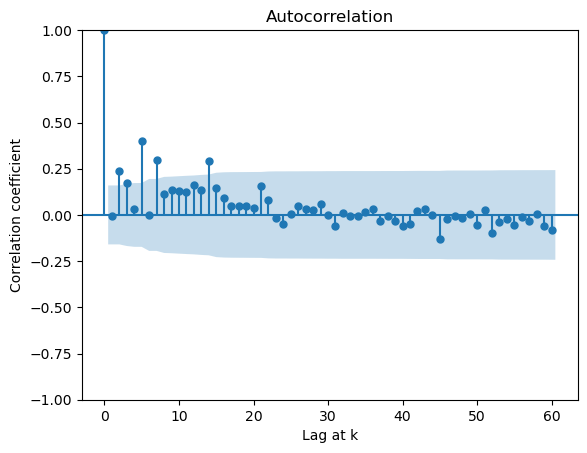

In [120]:
# ACF plot of residuals
fig = tsaplots.plot_acf(residuals, lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

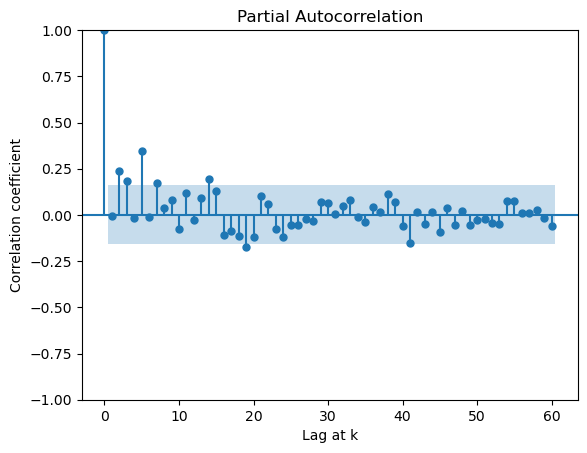

In [121]:
# ACF plot of residuals
fig = tsaplots.plot_pacf(residuals, lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

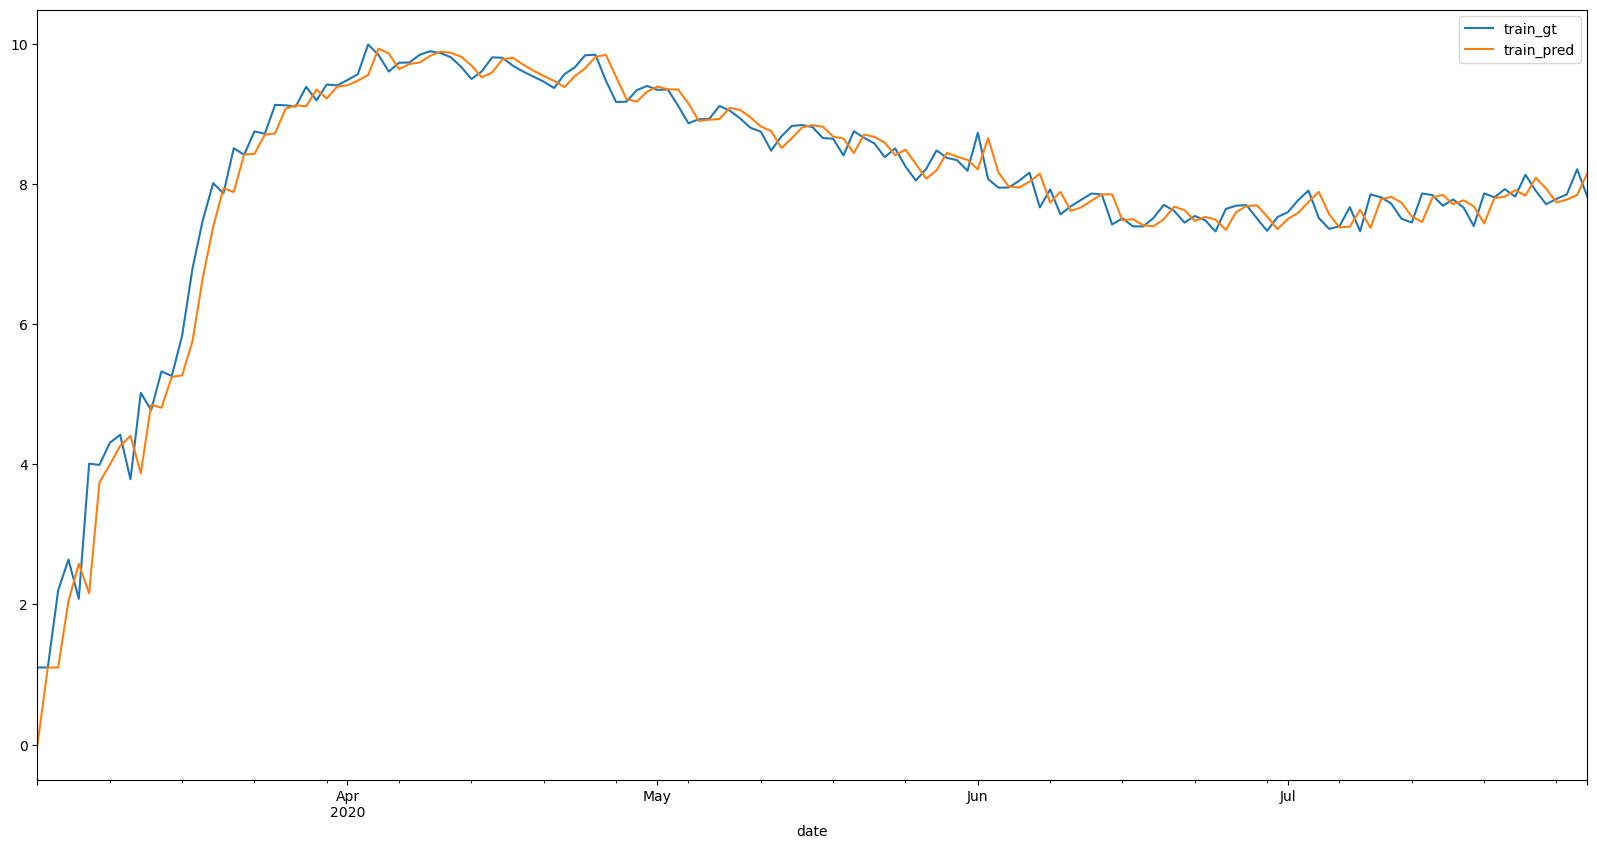

In [122]:
# Visualizing train data fitted values
ne_train_pred = ne_model_fit.fittedvalues
pd.concat([ne_train_transformed, ne_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

In [123]:
ne_test_pred = ne_model_fit.predict(start = len(ne_train_transformed), 
                                    end = len(ne_train_transformed) + len(ne_test_transformed) -1)

In [124]:
ne_test_pred = np.exp(ne_test_pred)

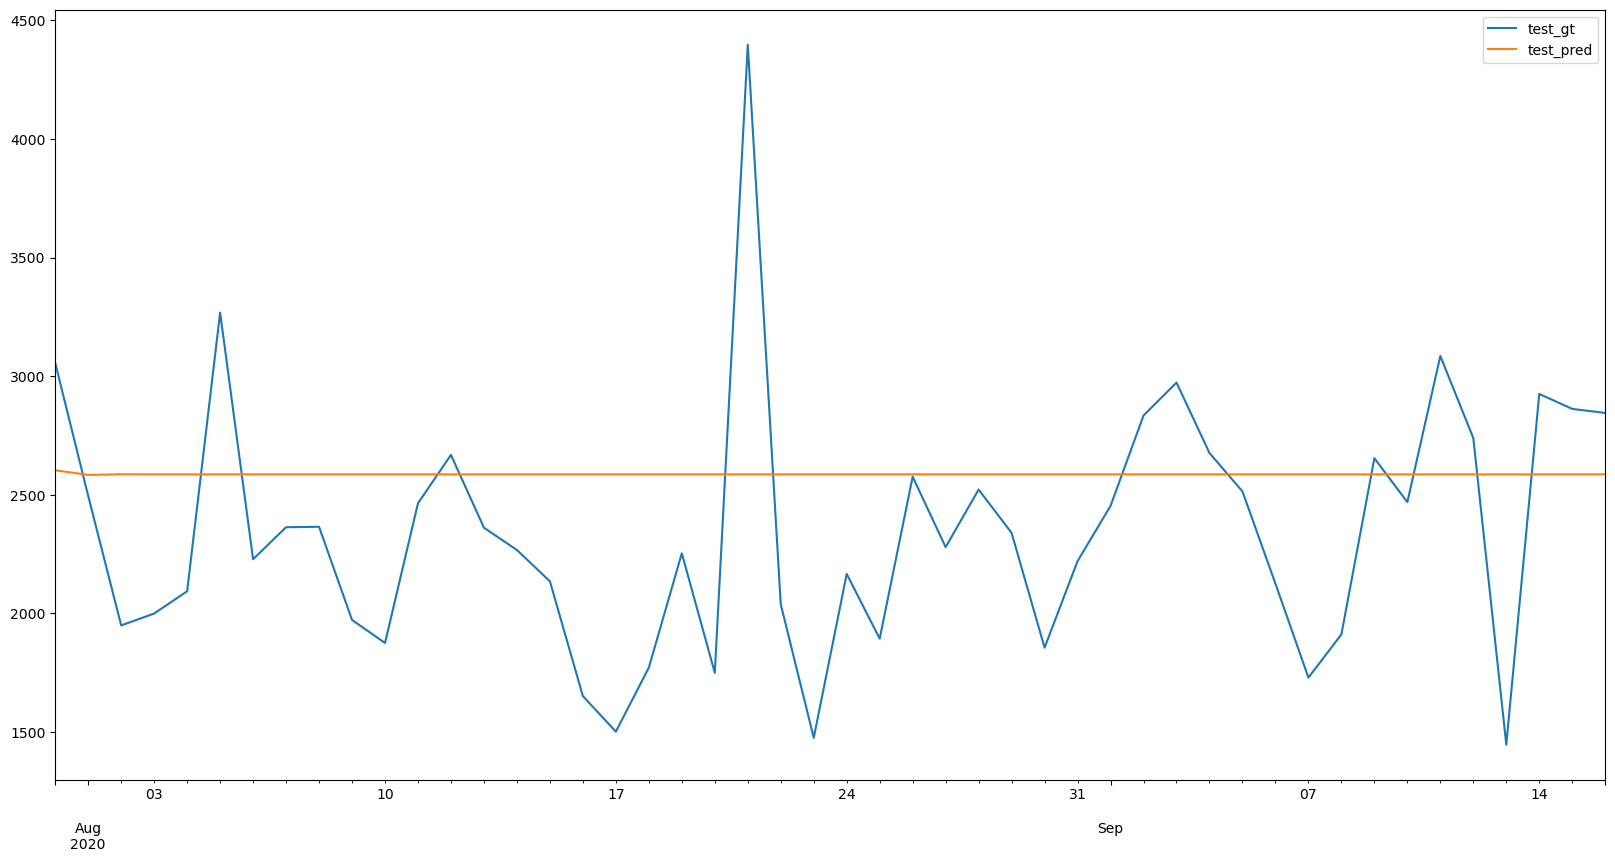

In [125]:
# Visualizing test data fitted values
pd.concat([ne_test_transformed, ne_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [126]:
# MAE on test
mean_absolute_error(ne_test_transformed, ne_test_pred)

465.69730819328714

# S Model
- (1, 1, 0)
    - AR Model
    - ACF graph shows tail off
    - Difference = 1 --> Series is difference stationary 
    - PACF shows cut off at lag 1 but performs too bad
- Residual stats show that residual looks like white noise with normal distribution and mean around 0
- ACF and PACF plots of residuals show barely any significant spikes for larger lags
    - Residuals are close to white noise
    - No bias in prediction
- MAE on train set = 1167 confirmed cases
- MAE on test set = 13097 confirmed cases

In [127]:
s_train_transformed = pd.merge(s_train.date, s_train["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
s_test_transformed = pd.merge(s_test.date, s_test["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)

In [128]:
s_train_transformed.set_index("date", inplace = True)
s_test_transformed.set_index("date", inplace = True)

## (1,1,0) Model

In [129]:
s_model = ARIMA(s_train_transformed, order=(1,1,0))
s_model_fit = s_model.fit()

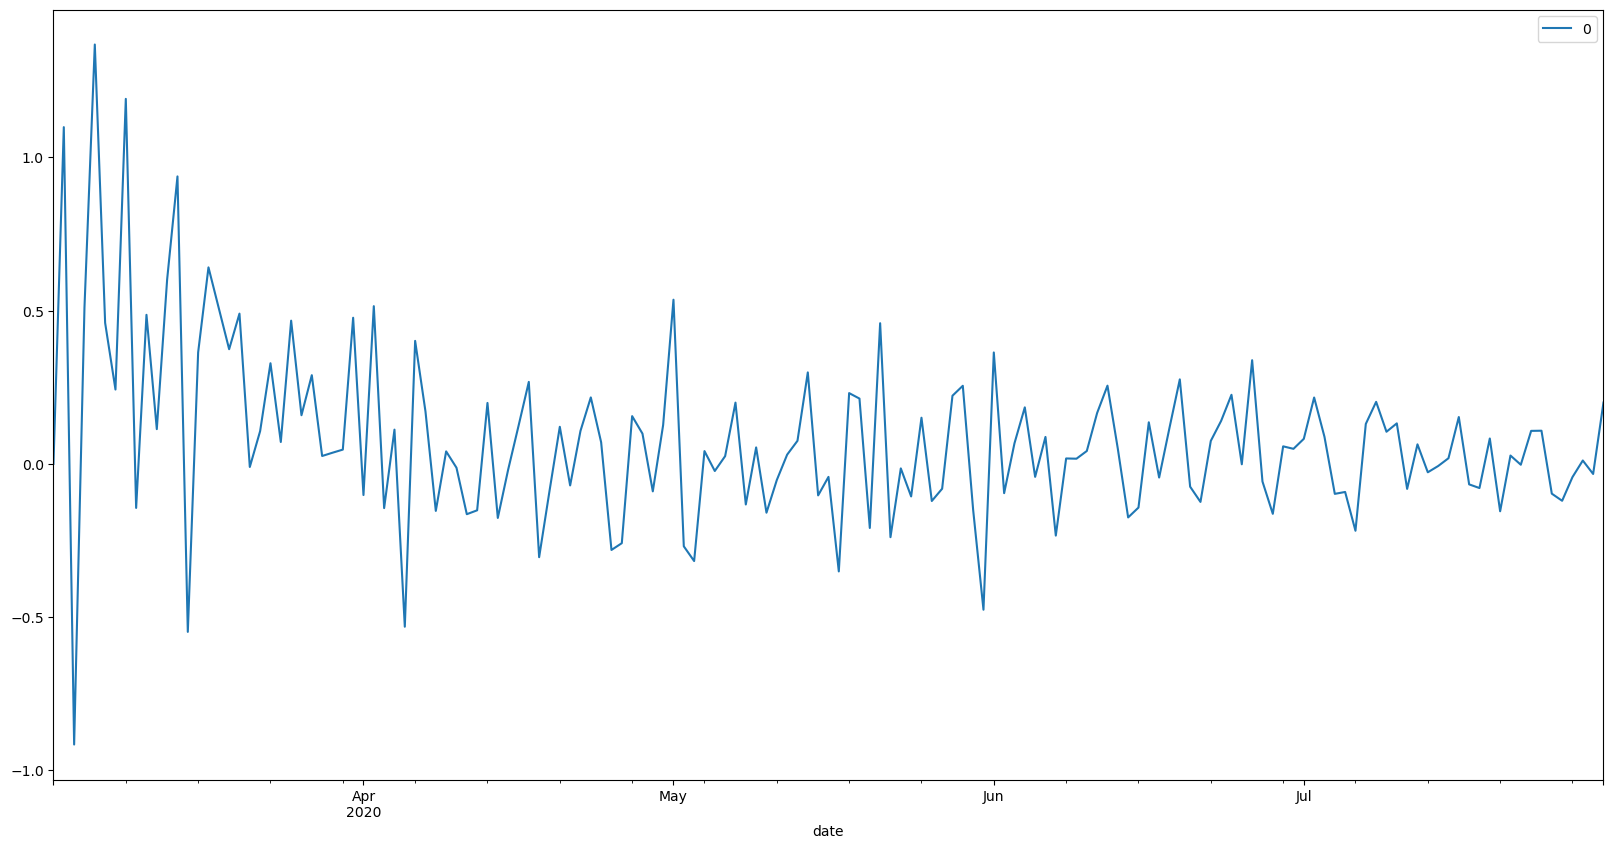

In [130]:
# line plot of residuals
residuals = DataFrame(s_model_fit.resid)
residuals.plot(figsize = (20,10))
plt.show()

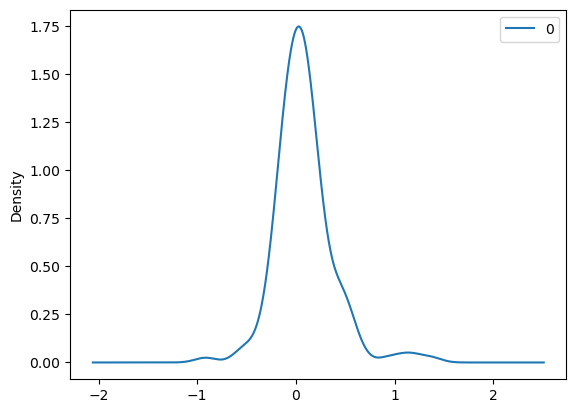

In [131]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

In [132]:
# summary stats of residuals
print(residuals.describe())

                0
count  151.000000
mean     0.079551
std      0.291326
min     -0.915680
25%     -0.089404
50%      0.049067
75%      0.199298
max      1.368180


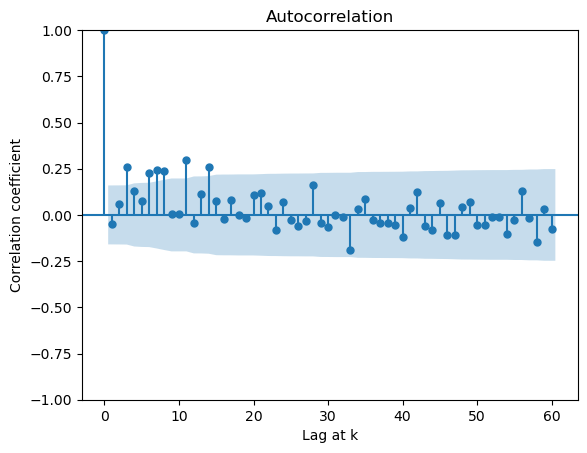

In [133]:
# ACF plot of residuals
fig = tsaplots.plot_acf(residuals, lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

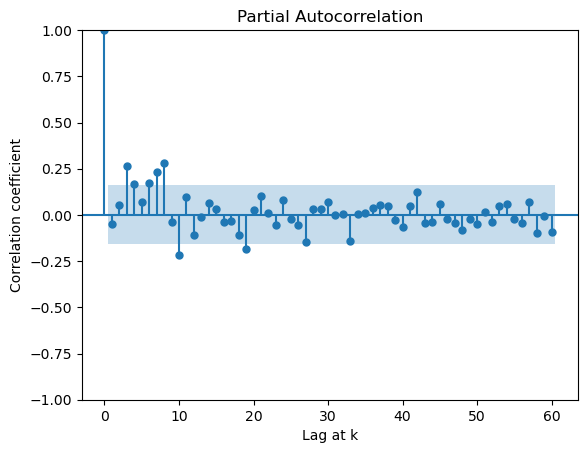

In [134]:
# ACF plot of residuals
fig = tsaplots.plot_pacf(residuals, lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

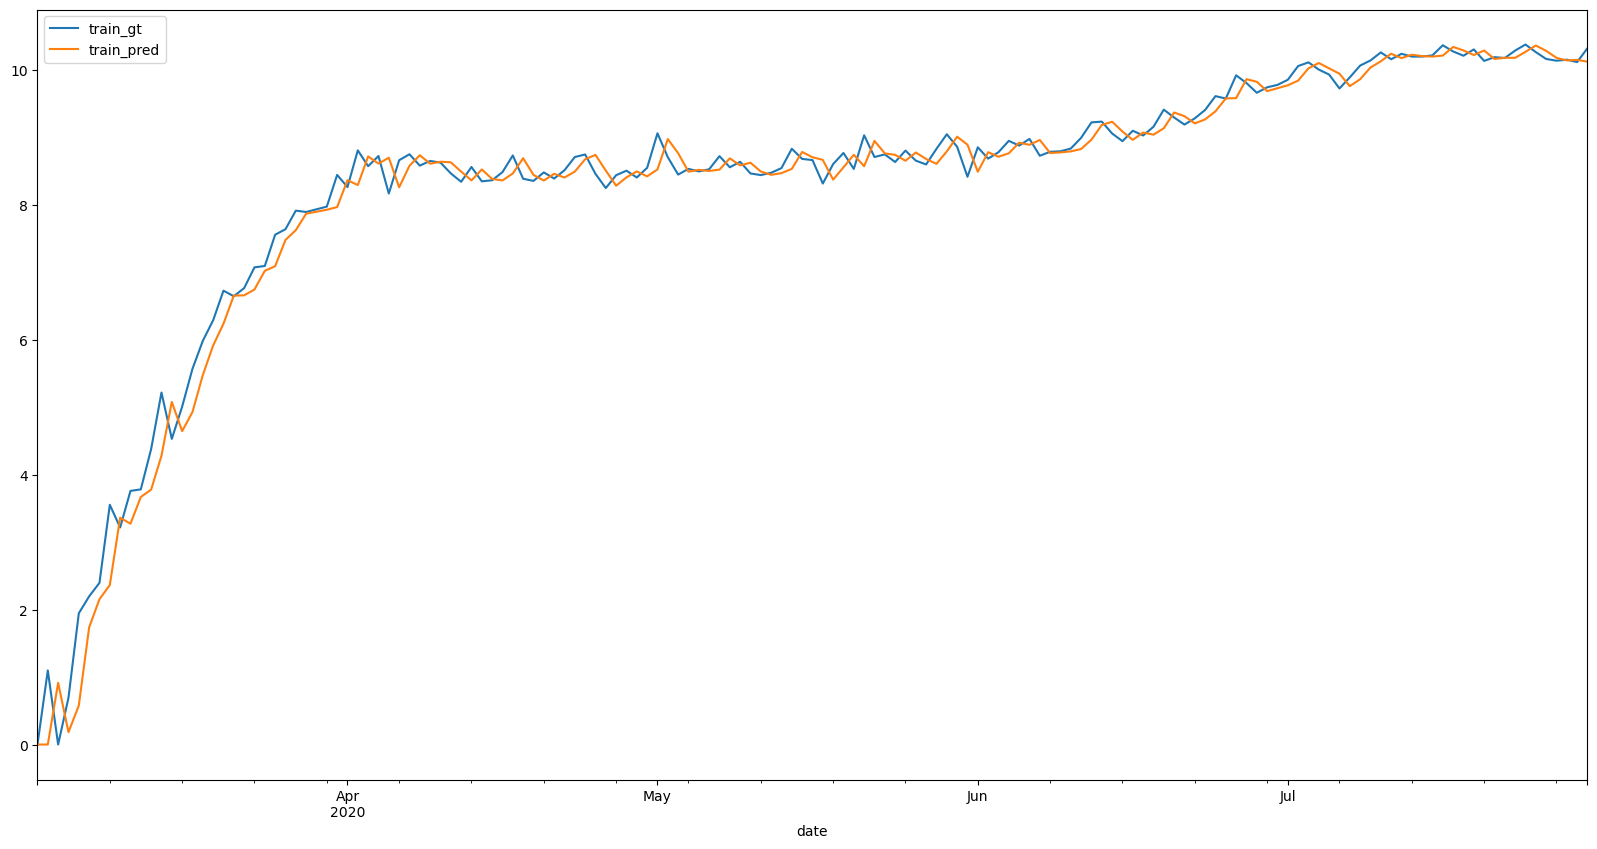

In [135]:
# Visualizing train data fitted values
s_train_pred = s_model_fit.fittedvalues
pd.concat([s_train_transformed, s_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

In [136]:
# MAE on train data
mean_absolute_error(np.exp(s_train_transformed), np.exp(s_train_pred))

1167.341722156665

## S Model Forecast

In [137]:
s_test_transformed.index = pd.to_datetime(s_test_transformed.index)

In [138]:
s_test_pred = s_model_fit.predict(start = len(s_train_transformed), 
                                  end = len(s_train_transformed) + len(s_test_transformed) -1)

In [139]:
s_test_pred = np.exp(s_test_pred)

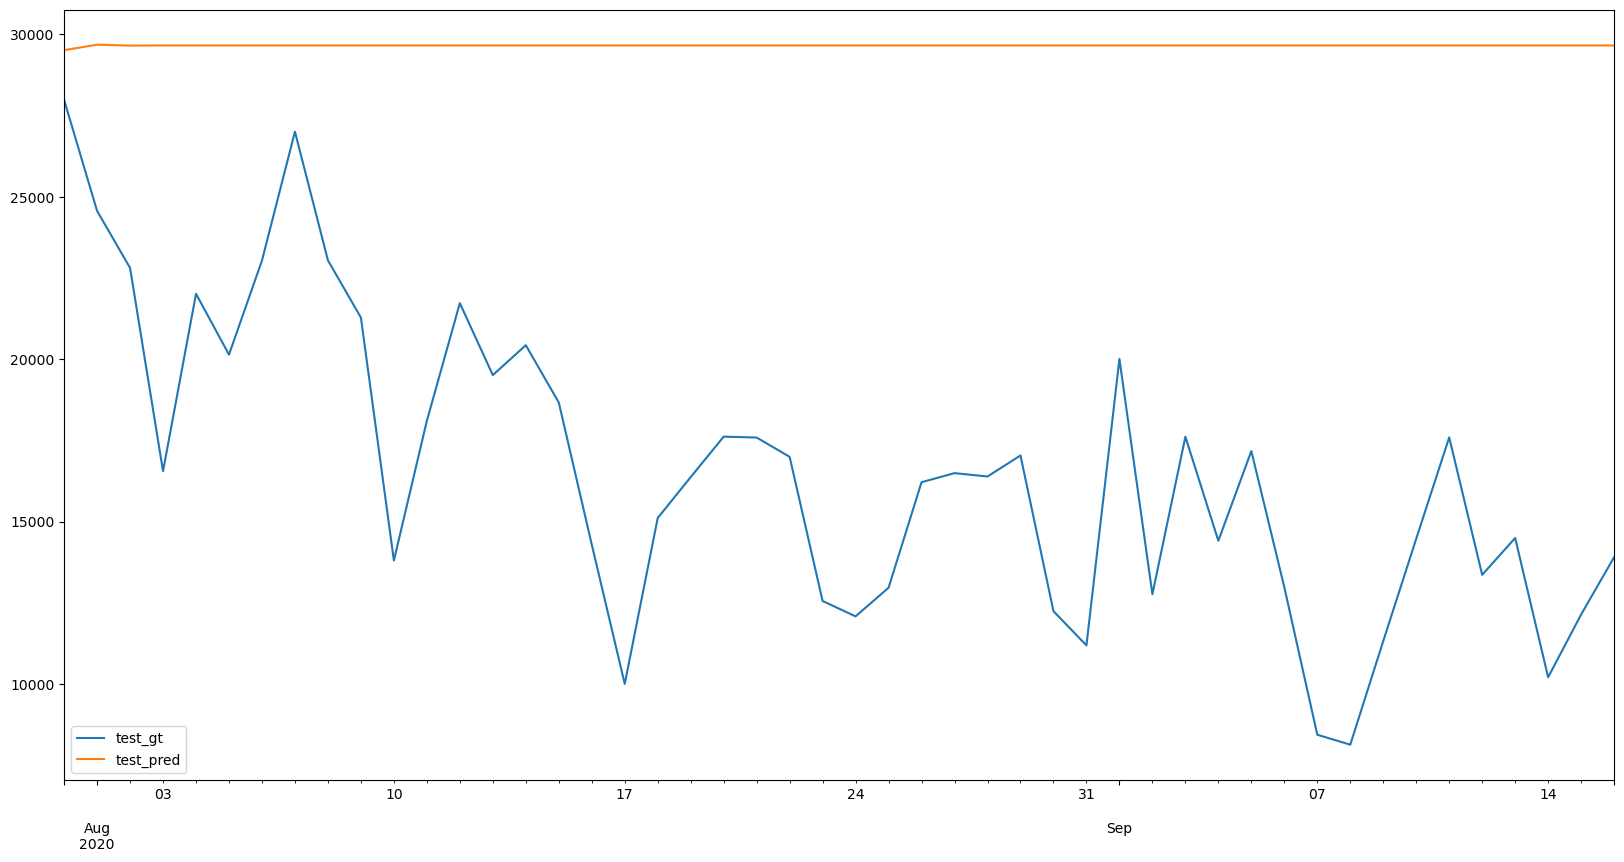

In [140]:
# Visualizing test data fitted values
pd.concat([s_test_transformed, s_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [141]:
# MAE on test set
mean_absolute_error(s_test_transformed, s_test_pred)

13097.057504510145

## Grid Search on S Region
- Best model from grid search performs way better than heuristic & trial-and-error models
- Best model (4,2,0)
    - MAE on validation set = 1992 confirmed cases
    - MAE on test set = 58767 confirmed cases

In [143]:
# Grid Search on S Region
p_values = [0, 1, 2, 4, 6, 8, 10, 11, 12, 13, 14, 15, 16]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
s_grid = evaluate_models(s_train_tune, s_val_tune, p_values, d_values, q_values)

In [144]:
s_grid.sort_values(by = "maes")[:5]

,model,maes
33,"(4, 2, 0)",1991.684120
30,"(4, 1, 0)",2006.753487
6,"(0, 2, 0)",2023.328605
4,"(0, 1, 1)",2027.656522
5,"(0, 1, 2)",2028.659768


In [145]:
s_model = ARIMA(s_train_transformed, order=(4,2,0))
s_model_fit = s_model.fit()

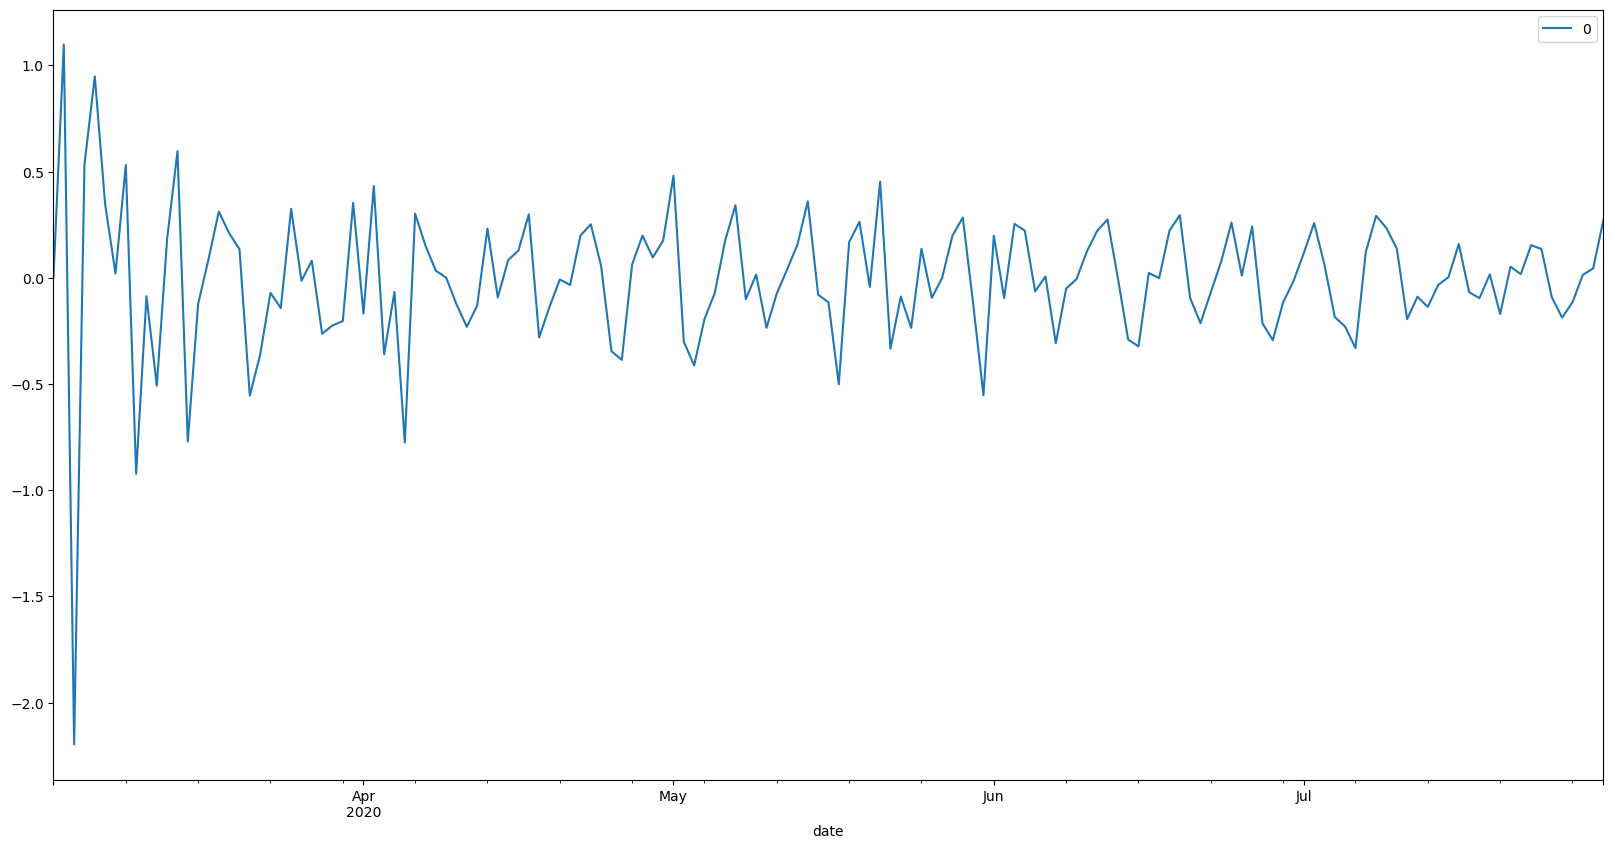

In [146]:
# line plot of residuals
residuals = DataFrame(s_model_fit.resid)
residuals.plot(figsize = (20,10))
plt.show()

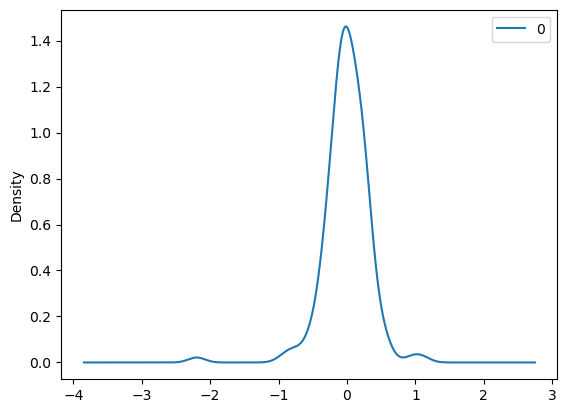

In [147]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

In [148]:
# summary stats of residuals
print(residuals.describe())

                0
count  151.000000
mean    -0.007532
std      0.332699
min     -2.197224
25%     -0.136810
50%      0.000660
75%      0.179964
max      1.098612


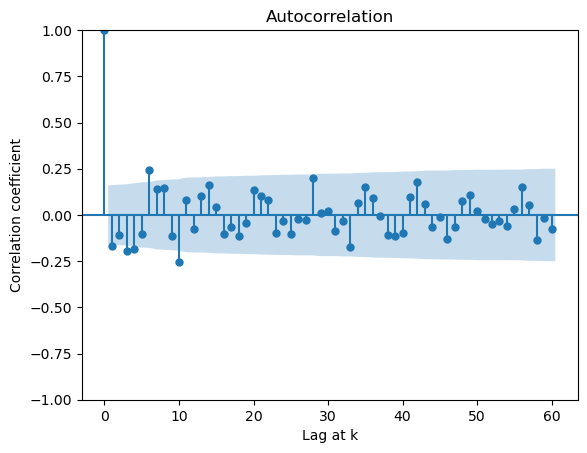

In [149]:
# ACF plot of residuals
fig = tsaplots.plot_acf(residuals, lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

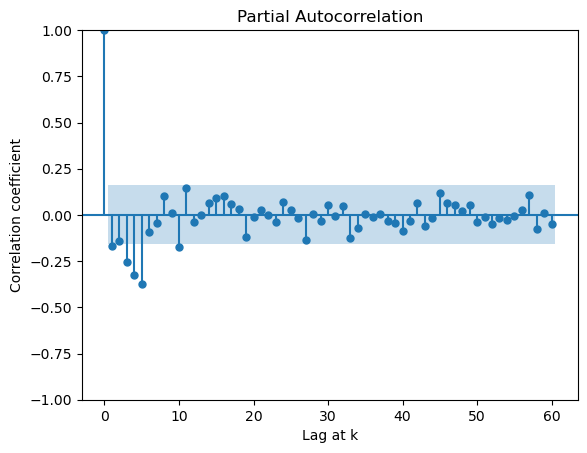

In [150]:
# ACF plot of residuals
fig = tsaplots.plot_pacf(residuals, lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

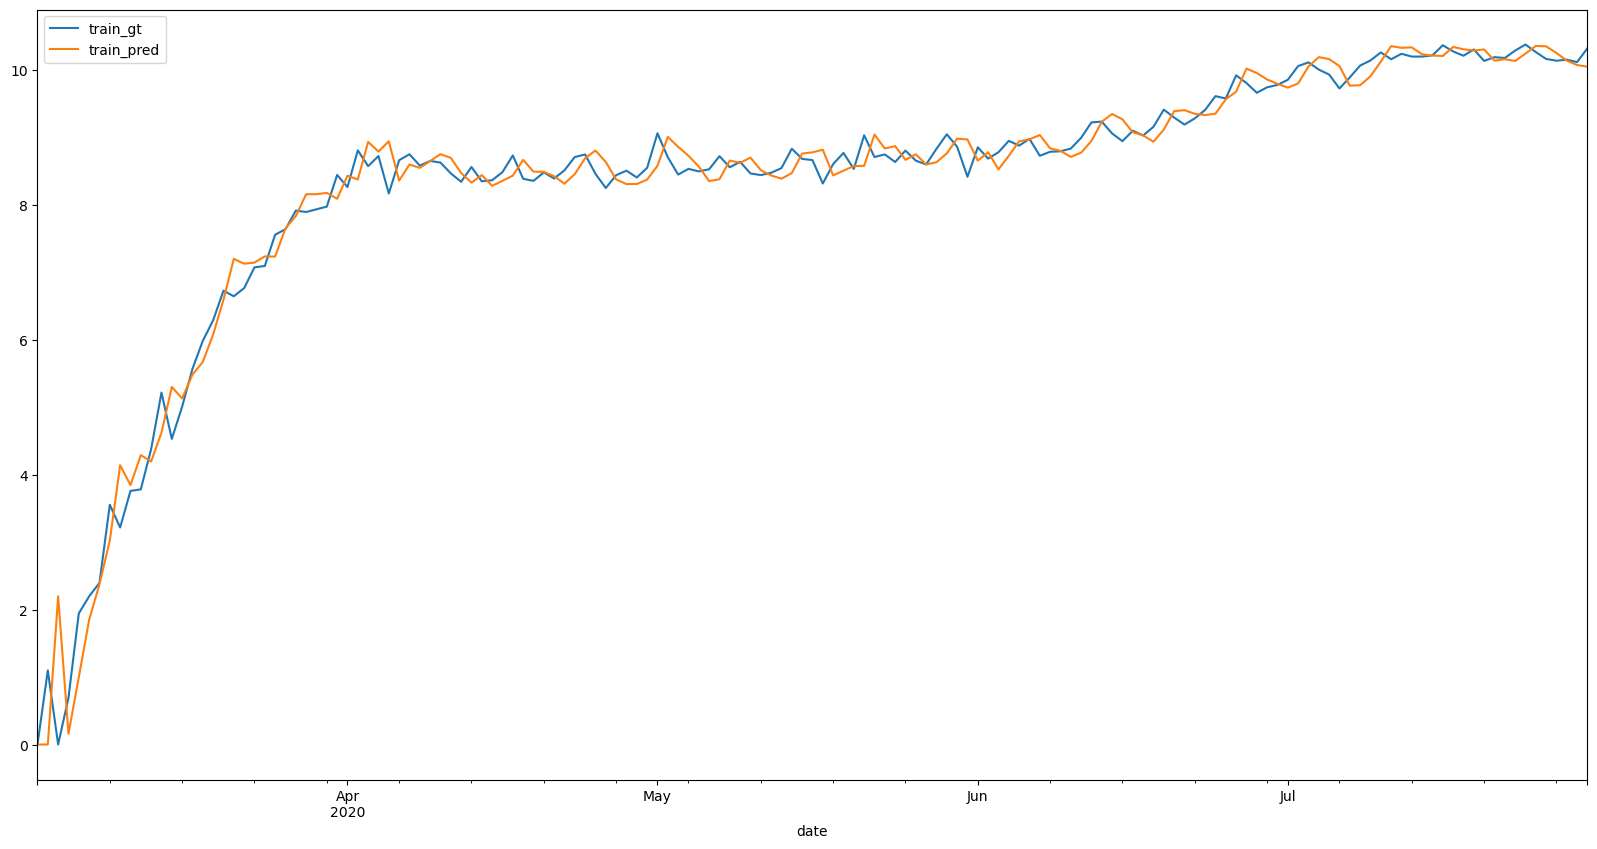

In [151]:
# Visualizing train data fitted values
s_train_pred = s_model_fit.fittedvalues
pd.concat([s_train_transformed, s_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

## S Model Forecast

In [152]:
s_test_pred = s_model_fit.predict(start = len(s_train_transformed), 
                                  end = len(s_train_transformed) + len(s_test_transformed) -1)

In [153]:
s_test_pred = np.exp(s_test_pred)

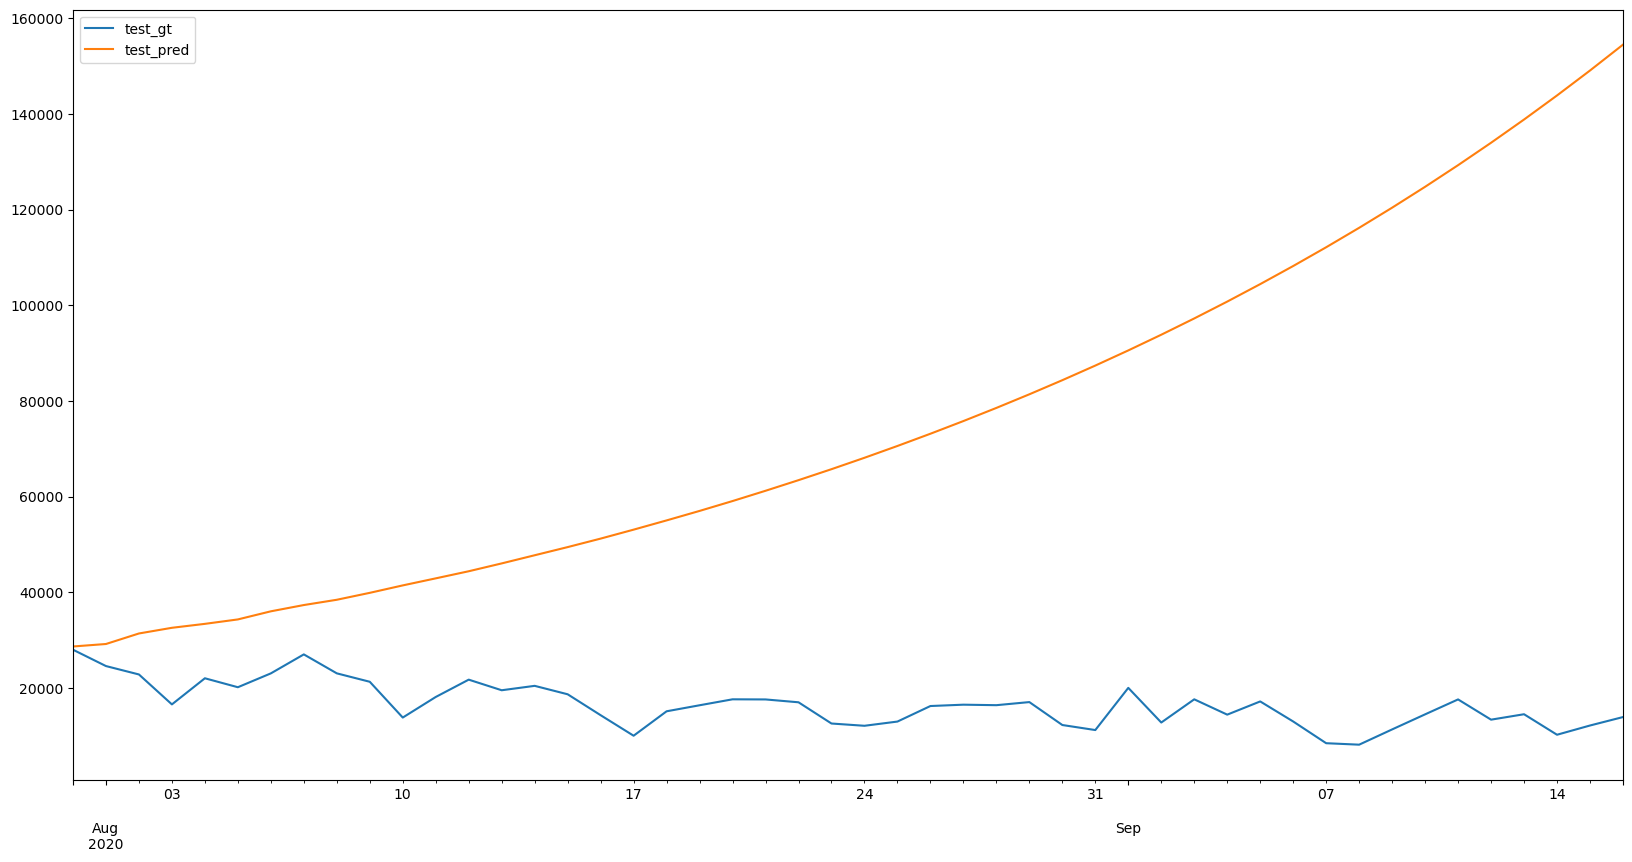

In [154]:
# Visualizing test data fitted values
pd.concat([s_test_transformed, s_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [155]:
# MAE on test data
mean_absolute_error(s_test_transformed, s_test_pred)

58766.869252830504